Number of qtl colocalized sets when 1 gene at a time, all v39 genes, or all genes

In [2]:
import numpy as np
import pandas as pd
import glob
from tqdm.notebook import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import networkx as nx
import os
import json
import matplotlib.patches as patches
import matplotlib.lines as mlines


In [3]:
gencode_ids = pd.read_table("/home/klawren/oak/gtex/data/other_references/gencode/gencode_id_matching.txt")

/local/scratch/klawren/slrmtmp.48919914/ipykernel_54220/2664361744.py:1: DtypeWarning: Columns (2,4) have mixed types. Specify dtype option on import or set low_memory=False.
  gencode_ids = pd.read_table("/home/klawren/oak/gtex/data/other_references/gencode/gencode_id_matching.txt")


In [4]:
# Define lncRNA category order and custom colors
lncrna_order = ["No new lncRNA", "Has new lncRNA", "Only new lncRNA"]
lncrna_colors = {
    'Only new lncRNA': '#b70657',      # deep magenta
    'Has new lncRNA': '#d6a5b7',      # light pink
    'No new lncRNA': 'grey'           # grey
}
color_list = [lncrna_colors[cat] for cat in lncrna_order]


gene_type_pal= {'lncRNA':'#b70657',
                            'sRNA':'#2D716F',
                            'pseudogene':'#734675',
                            'protein_coding':'#016895', 
                            'artifact':'grey'}

In [5]:
with open('/home/klawren/oak/gtex/data/other_references/gtex_colors.json') as f:
    tissue_df = pd.DataFrame.from_dict(json.load(f), orient='index')
tissue_df = tissue_df.reset_index(names='tissue_name')
tissue_df['tissue_color_hex'] = '#' + tissue_df['tissue_color_hex']
tissue_color_palette = sns.color_palette(tissue_df['tissue_color_hex'])

# get the versions of tissue ids in file names
tissue_df['tissue_file_name'] = (
    tissue_df['tissue_name']
    .str.replace('(', '', regex=False)
    .str.replace(')', '', regex=False)
    .str.replace(' - ', '_')
    .str.replace(' ', '_')
)
tissue_color_map = dict(zip(tissue_df['tissue_file_name'], tissue_df['tissue_color_hex']))

# Load in tissue sample sizes and add tissue_file_name to num_samples
sample_meta = pd.read_csv('/home/klawren/oak/gtex/data/other_references/v10/GTEx_Analysis_v10_Annotations_SampleAttributesDS.txt', sep='\t')
passed_samples = sample_meta[sample_meta['SMAFRZE'] == 'RNASEQ']
num_samples = pd.DataFrame(passed_samples.groupby('SMTSD').size()).rename(columns={0: 'num_samples'}).reset_index()

# Merge to get tissue_file_name into num_samples
num_samples = pd.merge(
    num_samples,
    tissue_df,
    left_on='SMTSD',
    right_on='tissue_name',
    how='left'
)

qtl_tissue_df = pd.merge(tissue_df, num_samples, left_on='tissue_name', right_on='SMTSD', how='left')
qtl_tissue_df = qtl_tissue_df[qtl_tissue_df['num_samples'] > 30]

/local/scratch/klawren/slrmtmp.48919914/ipykernel_54220/1806386243.py:18: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  sample_meta = pd.read_csv('/home/klawren/oak/gtex/data/other_references/v10/GTEx_Analysis_v10_Annotations_SampleAttributesDS.txt', sep='\t')


In [6]:
def categorize_locus(gene_types):
    """
    Categorize a locus based on the presence of 'new_lncRNA' in gene_type_grouped_highlight.
    """
    if not isinstance(gene_types, list) or len(gene_types) == 0:
        return "No new lncRNA"
    gene_types_flat = [item for sublist in gene_types for item in (sublist if isinstance(sublist, list) else [sublist])]
    has_new = any(gt == "new_lncRNA" for gt in gene_types_flat)
    only_new = all(gt == "new_lncRNA" for gt in gene_types_flat)
    if only_new:
        return "Only new lncRNA"
    elif has_new:
        return "Has new lncRNA"
    else:
        return "No new lncRNA"

In [7]:
def get_coloc_dfs(tissue_ids, coloc_output_dir, file_name, robust=True):
    all_coloc_dfs = []
    for tissue_id in tissue_ids:
        if robust:
            file_path = f"{coloc_output_dir}/{tissue_id}.xqtl_coloc.{file_name}.robust.txt"
        else:
            file_path = f"{coloc_output_dir}/{tissue_id}.xqtl_coloc.{file_name}.txt"
        try:
            df = pd.read_table(file_path)
            df['tissue_id'] = tissue_id
            df['ld_block'] = df['source_file'].str.split('/').str[-1].str.split('.').str[1]
            all_coloc_dfs.append(df)
        except FileNotFoundError:
            print(f"File not found for tissue_id: {tissue_id}")
    return pd.concat(all_coloc_dfs)

In [8]:
# split the robust results that somehow still have cos_npc < 0.5
# filter split with original_npc_outcome > .2
def split_robust_results(robust_df, full_df, cos_threshold=0.5, npc_threshold=0.75):
    low_cos = robust_df[(robust_df['cos_npc'] < cos_threshold) & (robust_df['cs_type'] == 'trait_shared')]
    print('Found', len(low_cos), 'robust results with cos_npc <', cos_threshold)
    low_cos['cs_type'] = 'trait_specific_from_shared'
    low_cos['converted_from_shared'] = True
    low_cos['original_cos_npc'] = low_cos['cos_npc']
    low_cos['cos_npc'] = np.nan
    low_cos['phenotype_id'] = low_cos['phenotype_id'].str.split(',')
    low_cos['neg_log10_p_value'] = low_cos['neg_log10_p_value'].str.split(', ')
    low_cos['original_npc_outcome'] = low_cos['npc_outcome'].str.split(', ')
    low_cos['npc_outcome'] = np.nan
    low_cos['original_cos_id'] = low_cos['cs_id']
    low_cos['cs_id'] = low_cos['cs_id'].str.split(':').str[1].str.split('_')
    low_cos = low_cos.explode(['phenotype_id', 'original_npc_outcome', 'neg_log10_p_value', 'cs_id'])
    low_cos['cs_id'] = 'ucos_new:' + low_cos['cs_id']

    # get the previously split robust results annotated
    full_df['individual_phenotype_id'] = full_df['phenotype_id'].str.split(',')
    full_df['original_npc_outcome'] = full_df['npc_outcome'].str.split(', ')
    full_df_exploded = full_df.explode(['individual_phenotype_id', 'original_npc_outcome'])
    trait_specific_from_shared = robust_df[robust_df['cs_type'] == 'trait_specific_from_shared'].drop(columns=['original_npc_outcome'])
    trait_specific_from_shared = pd.merge(
        trait_specific_from_shared,
        full_df_exploded[['individual_phenotype_id', 'tissue_id', 'ld_block', 'cs_id', 'original_npc_outcome']],
        left_on=['phenotype_id', 'tissue_id', 'ld_block', 'original_cos_id'],
        right_on=['individual_phenotype_id', 'tissue_id', 'ld_block', 'cs_id'],
        how='left',
        suffixes=('', '_merged')
    )

    split_robust_results = pd.concat([trait_specific_from_shared, low_cos])

    # keep those with original_npc_outcome > .2
    print('Found', len(split_robust_results), 'robust results')
    split_robust_results = split_robust_results[split_robust_results['original_npc_outcome'].astype(float) > npc_threshold]
    print('Found', len(split_robust_results), f'robust results with original_npc_outcome > {npc_threshold}')

    return pd.concat([split_robust_results,  robust_df[(robust_df['cos_npc'] > cos_threshold) & (robust_df['cs_type']!='trait_specific_from_shared')]])

In [ ]:
all_coloc_robust_dfs = get_coloc_dfs(tissue_df['tissue_file_name'].unique(), "/oak/stanford/groups/smontgom/dnachun/data/gtex/v10/output/coloc/single_tissue_qtl_only", file_name="all", robust=True)
all_coloc_dfs = get_coloc_dfs(tissue_df['tissue_file_name'].unique(), "/oak/stanford/groups/smontgom/dnachun/data/gtex/v10/output/coloc/single_tissue_qtl_only", file_name="all", robust=False)

robust_filtered_df = split_robust_results(all_coloc_robust_dfs, all_coloc_dfs)
robust_filtered_df['unique_cos_id'] = robust_filtered_df['cs_id'] + '_' + robust_filtered_df['tissue_id'] + '_' + robust_filtered_df['ld_block']
robust_filtered_df.to_csv("/oak/stanford/groups/smontgom/dnachun/data/gtex/v10/output/coloc/single_tissue_qtl_only.all.robust.txt", sep="\t", index=False)

In [45]:
# make a map of phenoytpes to npc outcome
all_coloc_dfs['individual_phenotype_id'] = all_coloc_dfs['phenotype_id'].str.split(',')
all_coloc_dfs['npc_outcome'] = all_coloc_dfs['npc_outcome'].str.split(', ')
shared_exploded = all_coloc_dfs[~all_coloc_dfs['npc_outcome'].isna()].drop_duplicates(subset=['phenotype_id', 'cs_id', 'tissue_id', 'ld_block']).explode(['individual_phenotype_id', 'npc_outcome'])



In [34]:
# filter the converted by shared based on matchin to npc_outcome in the full results
converted_coloc = all_coloc_robust_dfs[(all_coloc_robust_dfs['converted_from_shared'])].iloc[1]
full_coloc = all_coloc_dfs[(all_coloc_dfs['phenotype_id'].str.containconverted_coloc['phenotype_id']) & (all_coloc_dfs['cs_id'] == converted_coloc['original_cos_id']) & (all_coloc_dfs['ld_block'] == converted_coloc['ld_block']) & (all_coloc_dfs['tissue_id'] == converted_coloc['tissue_id'])]
full_coloc

,phenotype_id,variant_id,pip,neg_log10_p_value,cs_id,cs_type,cos_npc,npc_outcome,source_file,tissue_id,ld_block


<Axes: xlabel='neg_log10_p_value', ylabel='Count'>

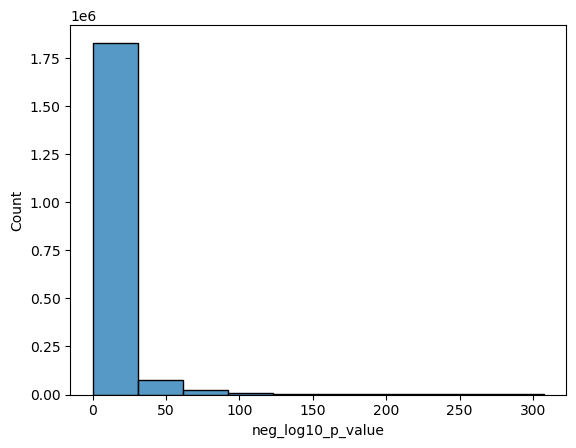

In [22]:
sns.histplot(all_coloc_robust_dfs[(all_coloc_robust_dfs['converted_from_shared'])]['neg_log10_p_value'].astype(float), bins=10)

In [194]:
# Add a column to all_coloc_dfs indicating the number of variants per credible set 
# A credible set is defined by the combination of phenotype_id, ld_block, tissue_id, and cs_id
cs_variant_counts = all_coloc_dfs.groupby(['phenotype_id', 'ld_block', 'tissue_id', 'cs_id']).size().reset_index(name='num_cs_variants')
all_coloc_dfs = pd.merge(all_coloc_dfs, cs_variant_counts, on=['phenotype_id', 'ld_block', 'tissue_id', 'cs_id'], how='left')

In [195]:
all_coloc_dfs['gene_id'] = all_coloc_dfs['phenotype_id'].str.split(',')
all_coloc_dfs['p_value'] = all_coloc_dfs['neg_log10_p_value'].str.split(', ')
all_coloc_exploded = all_coloc_dfs.drop_duplicates(subset=['phenotype_id', 'cs_id', 'tissue_id', 'ld_block']).explode(['gene_id', 'p_value'])
all_coloc_exploded['p_value'] = all_coloc_exploded['p_value'].astype(float)
all_coloc_exploded['gene_id_stable'] = all_coloc_exploded['gene_id'].str.split('.').str[1]
all_coloc_exploded = pd.merge(
    all_coloc_exploded,
    gencode_ids[['gene_id_stable', 'gene_type_grouped_highlight']],
    on='gene_id_stable',
    how='left')

In [196]:
all_coloc_annotated = all_coloc_exploded.groupby(['phenotype_id', 'cs_id', 'tissue_id', 'ld_block', 'cs_type']).agg({'gene_type_grouped_highlight': list, 'p_value': list, 'gene_id':list, 'cos_npc': 'first'}).reset_index()
all_coloc_annotated['num_genes'] = all_coloc_annotated['gene_id'].apply(len)
all_coloc_annotated['proxitropy'] = all_coloc_annotated['num_genes']>1
#all_coloc_annotated.to_csv("/oak/stanford/groups/smontgom/dnachun/data/gtex/v10/output/coloc/single_tissue_qtl_only.all.annotated.txt", sep="\t", index=False)

<Axes: xlabel='cos_npc', ylabel='Percent'>

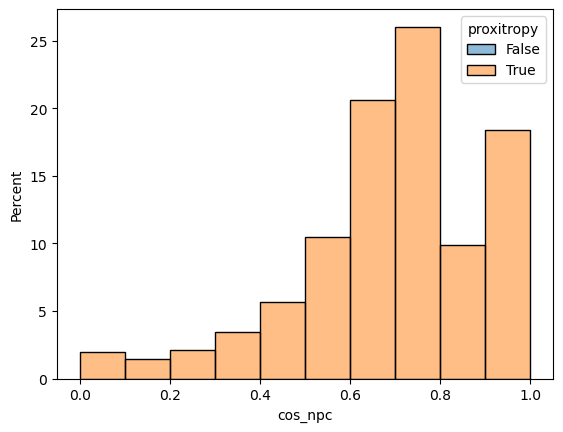

In [197]:
sns.histplot(all_coloc_annotated, x='cos_npc', bins=10, hue='proxitropy', stat='percent')

In [198]:
# mark and split strong cos
# TODO switch to robust coloc results

cos_npc_threshold = 0.75
all_coloc_exploded_strong = all_coloc_exploded.copy()
all_coloc_exploded_strong['weak_cos'] = all_coloc_exploded_strong['cos_npc'] < cos_npc_threshold 
print('{} weak colocalization, {}% of total'.format(all_coloc_exploded_strong['weak_cos'].sum(), all_coloc_exploded_strong['weak_cos'].mean()*100))

all_coloc_exploded_strong["phenotype_id"] = np.where(all_coloc_exploded_strong["weak_cos"], all_coloc_exploded_strong["phenotype_id"] + "_split", all_coloc_exploded_strong["phenotype_id"])
all_coloc_exploded_strong['cs_id'] = np.where(all_coloc_exploded_strong['weak_cos'], all_coloc_exploded_strong['cs_id'] + '_' + all_coloc_exploded_strong['gene_id'], all_coloc_exploded_strong['cs_id'])
all_coloc_exploded_strong['cs_type'] = np.where(all_coloc_exploded_strong['weak_cos'], 'join_but_weak', all_coloc_exploded_strong['cs_type'])


all_coloc_strong_annotated = all_coloc_exploded_strong.groupby(['phenotype_id', 'cs_id', 'tissue_id', 'ld_block', 'cs_type']).agg({'gene_type_grouped_highlight': list, 'p_value': list, 'gene_id':list, 'cos_npc': 'first'}).reset_index()
all_coloc_strong_annotated['num_genes'] = all_coloc_strong_annotated['gene_id'].apply(len)
all_coloc_strong_annotated['proxitropy'] = all_coloc_strong_annotated['num_genes']>1
all_coloc_strong_annotated.to_csv("/oak/stanford/groups/smontgom/dnachun/data/gtex/v10/output/coloc/single_tissue_qtl_only.all.weak_split.annotated.txt", sep="\t", index=False)

313536 weak colocalization, 41.18034130445918% of total


In [199]:
all_coloc_exploded_strong.groupby('weak_cos')['p_value'].describe()

,count,mean,std,min,25%,50%,75%,max
weak_cos,,,,,,,,
False,447837.0,inf,NaN,0.002727,6.51617,13.97760,27.36190,inf
True,313536.0,inf,NaN,0.003563,3.74996,4.58856,6.66511,inf


<Axes: xlabel='p_value', ylabel='Percent'>

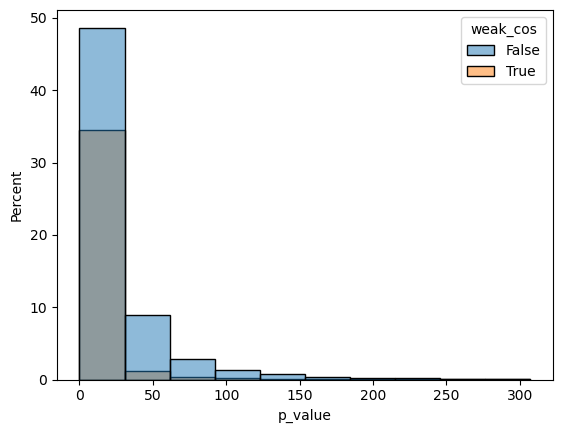

In [200]:
sns.histplot(all_coloc_exploded_strong.head(100000), x='p_value', bins=10, hue='weak_cos', stat='percent')

In [201]:
print(f'Before spliting: {all_coloc_annotated["proxitropy"].mean()}')
print(f'After spliting: {all_coloc_strong_annotated["proxitropy"].mean()}')

Before spliting: 0.5699462307984532
After spliting: 0.15342019037617516


## new estimate of proxitropy

In [202]:
all_coloc_strong_annotated['index_gene_type'] = all_coloc_strong_annotated['gene_type_grouped_highlight']
all_coloc_strong_type_exploded = all_coloc_strong_annotated.explode('index_gene_type')


all_coloc_pl_exploded = all_coloc_strong_type_exploded[all_coloc_strong_type_exploded['index_gene_type'].isin(['new_lncRNA', 'existing_lncRNA', 'protein_coding'])]
all_coloc_pl_exploded['gene_type'] = np.where(all_coloc_pl_exploded['index_gene_type'] == 'protein_coding', 'protein_coding', 'lncRNA')


lncrna_joint = all_coloc_pl_exploded[all_coloc_pl_exploded['gene_type'] == 'lncRNA'].groupby('tissue_id')['proxitropy'].mean().reset_index()
lncrna_joint['biotype'] = 'lncRNA'
protien_joint = all_coloc_pl_exploded[all_coloc_pl_exploded['gene_type'] == 'protein_coding'].groupby('tissue_id')['proxitropy'].mean().reset_index()
protien_joint['biotype'] = 'protein_coding'

joint_proxitorpy = pd.concat([lncrna_joint, protien_joint])
joint_proxitorpy['share_rate'] = joint_proxitorpy['proxitropy'] * 100
joint_proxitorpy

/local/scratch/klawren/slrmtmp.48897955/ipykernel_6632/3829278298.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_coloc_pl_exploded['gene_type'] = np.where(all_coloc_pl_exploded['index_gene_type'] == 'protein_coding', 'protein_coding', 'lncRNA')


,tissue_id,proxitropy,biotype,share_rate
0,Adipose_Subcutaneous,0.452625,lncRNA,45.262532
1,Adipose_Visceral_Omentum,0.415779,lncRNA,41.577902
2,Adrenal_Gland,0.389924,lncRNA,38.992379
3,Artery_Aorta,0.429764,lncRNA,42.976381
4,Artery_Coronary,0.351583,lncRNA,35.158255
...,...,...,...,...
45,Testis,0.353323,protein_coding,35.332338
46,Thyroid,0.393004,protein_coding,39.300412
47,Uterus,0.312171,protein_coding,31.217095
48,Vagina,0.311190,protein_coding,31.118980


/local/scratch/klawren/slrmtmp.48897955/ipykernel_6632/2836356713.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(
/local/scratch/klawren/slrmtmp.48897955/ipykernel_6632/2836356713.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(


biotype
lncRNA            38.373897
protein_coding    31.601733
Name: share_rate, dtype: float64


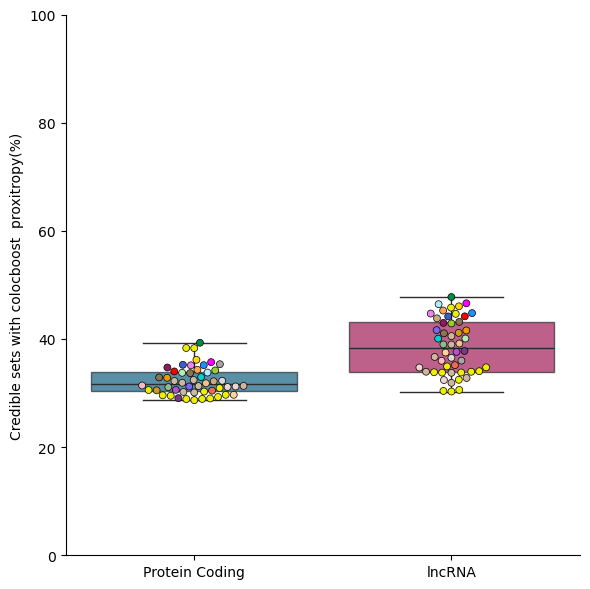

In [203]:
fig, ax = plt.subplots(figsize=(6, 6))
biotype_order = ['protein_coding', 'lncRNA']

# Boxplot with x as collapsed biotype and y as share rate (rotated 90 degrees)
ax = sns.boxplot(
    data=joint_proxitorpy,
    x='biotype', y='share_rate',
    order=biotype_order,
    ax=ax, zorder=0, palette=gene_type_pal, 
    boxprops=dict(alpha=0.7),
)

# Swarmplot with x as collapsed biotype and y as share rate
sns.swarmplot(
    data=joint_proxitorpy,
    x='biotype', y='share_rate',
    order=biotype_order,
    hue='tissue_id', palette=tissue_color_map,
    s=5, legend=False, ax=ax, zorder=1, linewidth=0.5, edgecolor='black'
)

ax.set_xlabel('')
ax.set_ylabel('Credible sets with colocboost  proxitropy(%)')
ax.set_xticklabels(
    ['Protein Coding', 'lncRNA'],
    ha='center',
)
print(joint_proxitorpy.groupby('biotype')['share_rate'].median())
ax.set_ylim(0, 100)
sns.despine()
plt.tight_layout()

### lncRNA specific sets, weak coloc does count here

In [204]:
# Filter to rows where gene_type_grouped_highlight contains only 'new_lncRNA'
new_lnc_specific = all_coloc_annotated[all_coloc_annotated['gene_type_grouped_highlight'].apply(lambda x: set([gt for gt in x if pd.notnull(gt)]).issubset({'new_lncRNA'}))]

# Count number of such loci per tissue
new_lncrna_specific_counts = new_lnc_specific[['tissue_id']].value_counts().sort_index().reset_index()
new_lncrna_specific_counts.columns = ['tissue_id', 'num_loci']

# Merge with tissue_df to get tissue_abbrv for x-ticks
new_lncrna_specific_bar_df = new_lncrna_specific_counts.merge(
    tissue_df[['tissue_file_name', 'tissue_abbrv']],
    left_on='tissue_id',
    right_on='tissue_file_name',
    how='left'
)

348.5


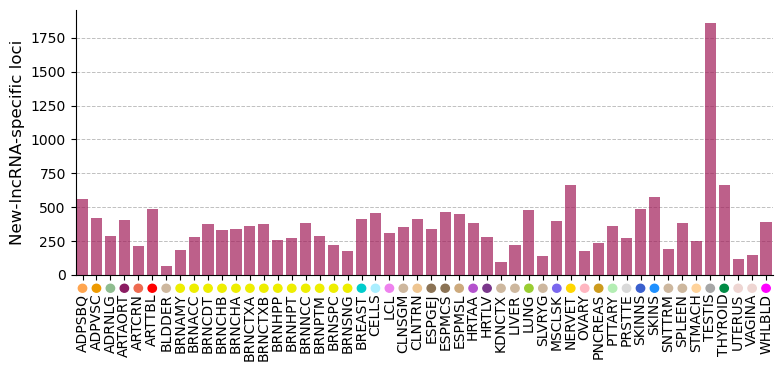

In [205]:
fig, ax = plt.subplots(figsize=(9, 5))

# Vertical barplot: tissue on x axis, number of loci on y axis
# Stacked barplot: new_lncRNA on top of existing_lncRNA for each tissue
sns.barplot(
    data=new_lncrna_specific_bar_df,
    x='tissue_abbrv',
    y='num_loci',
    ax=ax, 
    color='#b70657',
    alpha=0.7
)

ax.set_ylabel('New-lncRNA-specific loci', fontsize=12)
ax.set_xlabel('')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Add horizontal grid lines
ax.yaxis.grid(True, which='major', linestyle='--', linewidth=0.7, color='gray', alpha=0.5)
ax.set_axisbelow(True)

# # Add number at the top of the bar for each tissue if nonzero
# for i, (num, tissue_abbrv) in enumerate(zip(bar_df['num_loci'], bar_df['tissue_abbrv'])):
#     if num > 0:
#         ax.text(i, num + 0.5, f"{int(num)}", va='bottom', ha='center', fontsize=10)

# Add colored dots below the x axis for each tissue
xticklabels = [item.get_text() for item in ax.get_xticklabels()]
xticks = ax.get_xticks()
ax.tick_params(axis='x', pad=10, rotation=90)
x_positions = np.array(xticks)
for x, tissue_abbrv in zip(x_positions, xticklabels):
    tissue_id = new_lncrna_specific_bar_df.loc[new_lncrna_specific_bar_df['tissue_abbrv'] == tissue_abbrv, 'tissue_id'].values[0]
    color = tissue_color_map.get(tissue_id, "#888888")
    circle = patches.Ellipse(
        (x, -0.05 * ax.get_ylim()[1]), width=0.6, height=0.03 * ax.get_ylim()[1],
        transform=ax.transData,
        color=color, clip_on=False
    )
    ax.add_patch(circle)

plt.subplots_adjust(bottom=0.35)
print(new_lncrna_specific_bar_df['num_loci'].median())
plt.show()

### compare the number qtl-gene associations

In [206]:
egene_results_dir = "/home/klawren/oak/gtex/output/qtl/GTEx_Analysis_v11_eQTL"

# load in the eSusie files
esusie = []
esusie_tissues = []
for id, row in tissue_df.iterrows():
    try:
        esusie.append(pd.read_parquet(f"{egene_results_dir}/{row['tissue_file_name']}.v11.eQTLs.SuSiE_summary.parquet"))
        esusie_tissues.append(row['tissue_file_name'])
    except:
        print(f"No eSusie results for {row['tissue_file_name']}")

esusie_df = pd.concat(esusie, keys=esusie_tissues, names=['tissue_id', 'idx']).reset_index(level=1, drop=True).reset_index()
esusie_df = pd.merge(esusie_df, gencode_ids[['gene_id_v47', 'gene_type_grouped_highlight']], left_on='phenotype_id', right_on='gene_id_v47', how='left')


# Count the number of unique (phenotype_id, cs_id) pairs per tissue
individual_loci = (
    esusie_df
    .drop_duplicates(subset=['tissue_id', 'phenotype_id', 'cs_id'])
    .groupby('tissue_id')[['phenotype_id', 'cs_id']]
    .size()
    .sort_index()
).reset_index()
individual_loci.columns = ['tissue_id', 'num_loci']

# Merge with tissue_df to get tissue_abbrv for x-ticks
individual_loci = individual_loci.merge(
    num_samples[['tissue_file_name', 'tissue_abbrv', 'num_samples']],
    left_on='tissue_id',
    right_on='tissue_file_name',
    how='left'
)

No eSusie results for Artery_Femoral
No eSusie results for Cervix_Ectocervix
No eSusie results for Cervix_Endocervix
No eSusie results for Fallopian_Tube
No eSusie results for Kidney_Medulla
No eSusie results for Stomach_Mixed_Cell
No eSusie results for Stomach_Mucosa
No eSusie results for Stomach_Muscularis


In [207]:
v10_egene_results_dir = "/home/klawren/oak/gtex/data/other_references/v10/qtls/GTEx_v10_SuSiE_eQTL"

# load in the eSusie files
v10_esusie = []
v10_esusie_tissues = []
for id, row in tissue_df.iterrows():
    try:
        v10_esusie.append(pd.read_parquet(f"{v10_egene_results_dir}/{row['tissue_file_name']}.v10.eQTLs.SuSiE_summary.parquet"))
        v10_esusie_tissues.append(row['tissue_file_name'])
    except:
        print(f"No eSusie results for {row['tissue_file_name']}")

v10_esusie_df = pd.concat(v10_esusie, keys=v10_esusie_tissues, names=['tissue_id', 'idx']).reset_index(level=1, drop=True).reset_index()
v10_esusie_df = pd.merge(v10_esusie_df, gencode_ids[['gene_id_v47', 'gene_type_grouped_highlight']], left_on='phenotype_id', right_on='gene_id_v47', how='left')


# Count the number of unique (phenotype_id, cs_id) pairs per tissue
v10_individual_loci = (
    v10_esusie_df
    .drop_duplicates(subset=['tissue_id', 'phenotype_id', 'cs_id'])
    .groupby('tissue_id')[['phenotype_id', 'cs_id']]
    .size()
    .sort_index()
).reset_index()
v10_individual_loci.columns = ['tissue_id', 'num_loci']

# Merge with tissue_df to get tissue_abbrv for x-ticks
v10_individual_loci = v10_individual_loci.merge(
    num_samples[['tissue_file_name', 'tissue_abbrv', 'num_samples']],
    left_on='tissue_id',
    right_on='tissue_file_name',
    how='left'
)

No eSusie results for Artery_Femoral
No eSusie results for Cervix_Ectocervix
No eSusie results for Cervix_Endocervix
No eSusie results for Fallopian_Tube
No eSusie results for Kidney_Medulla
No eSusie results for Stomach_Mixed_Cell
No eSusie results for Stomach_Mucosa
No eSusie results for Stomach_Muscularis


In [222]:
# count the number of credible sets (double counting if multiple genes, equivilent to single gene model)
total_gene_qtl_counts = all_coloc_exploded['tissue_id'].value_counts().sort_index()
total_gene_qtl_counts = total_gene_qtl_counts.reset_index()
total_gene_qtl_counts.columns = ['tissue_id', 'num_gene_cs']
colocboost_loci = pd.merge(total_gene_qtl_counts,
    num_samples[['tissue_file_name', 'tissue_abbrv', 'num_samples']],
    left_on='tissue_id',
    right_on='tissue_file_name',
    how='left'
)

Median increase in number of loci per tissue: 475.0


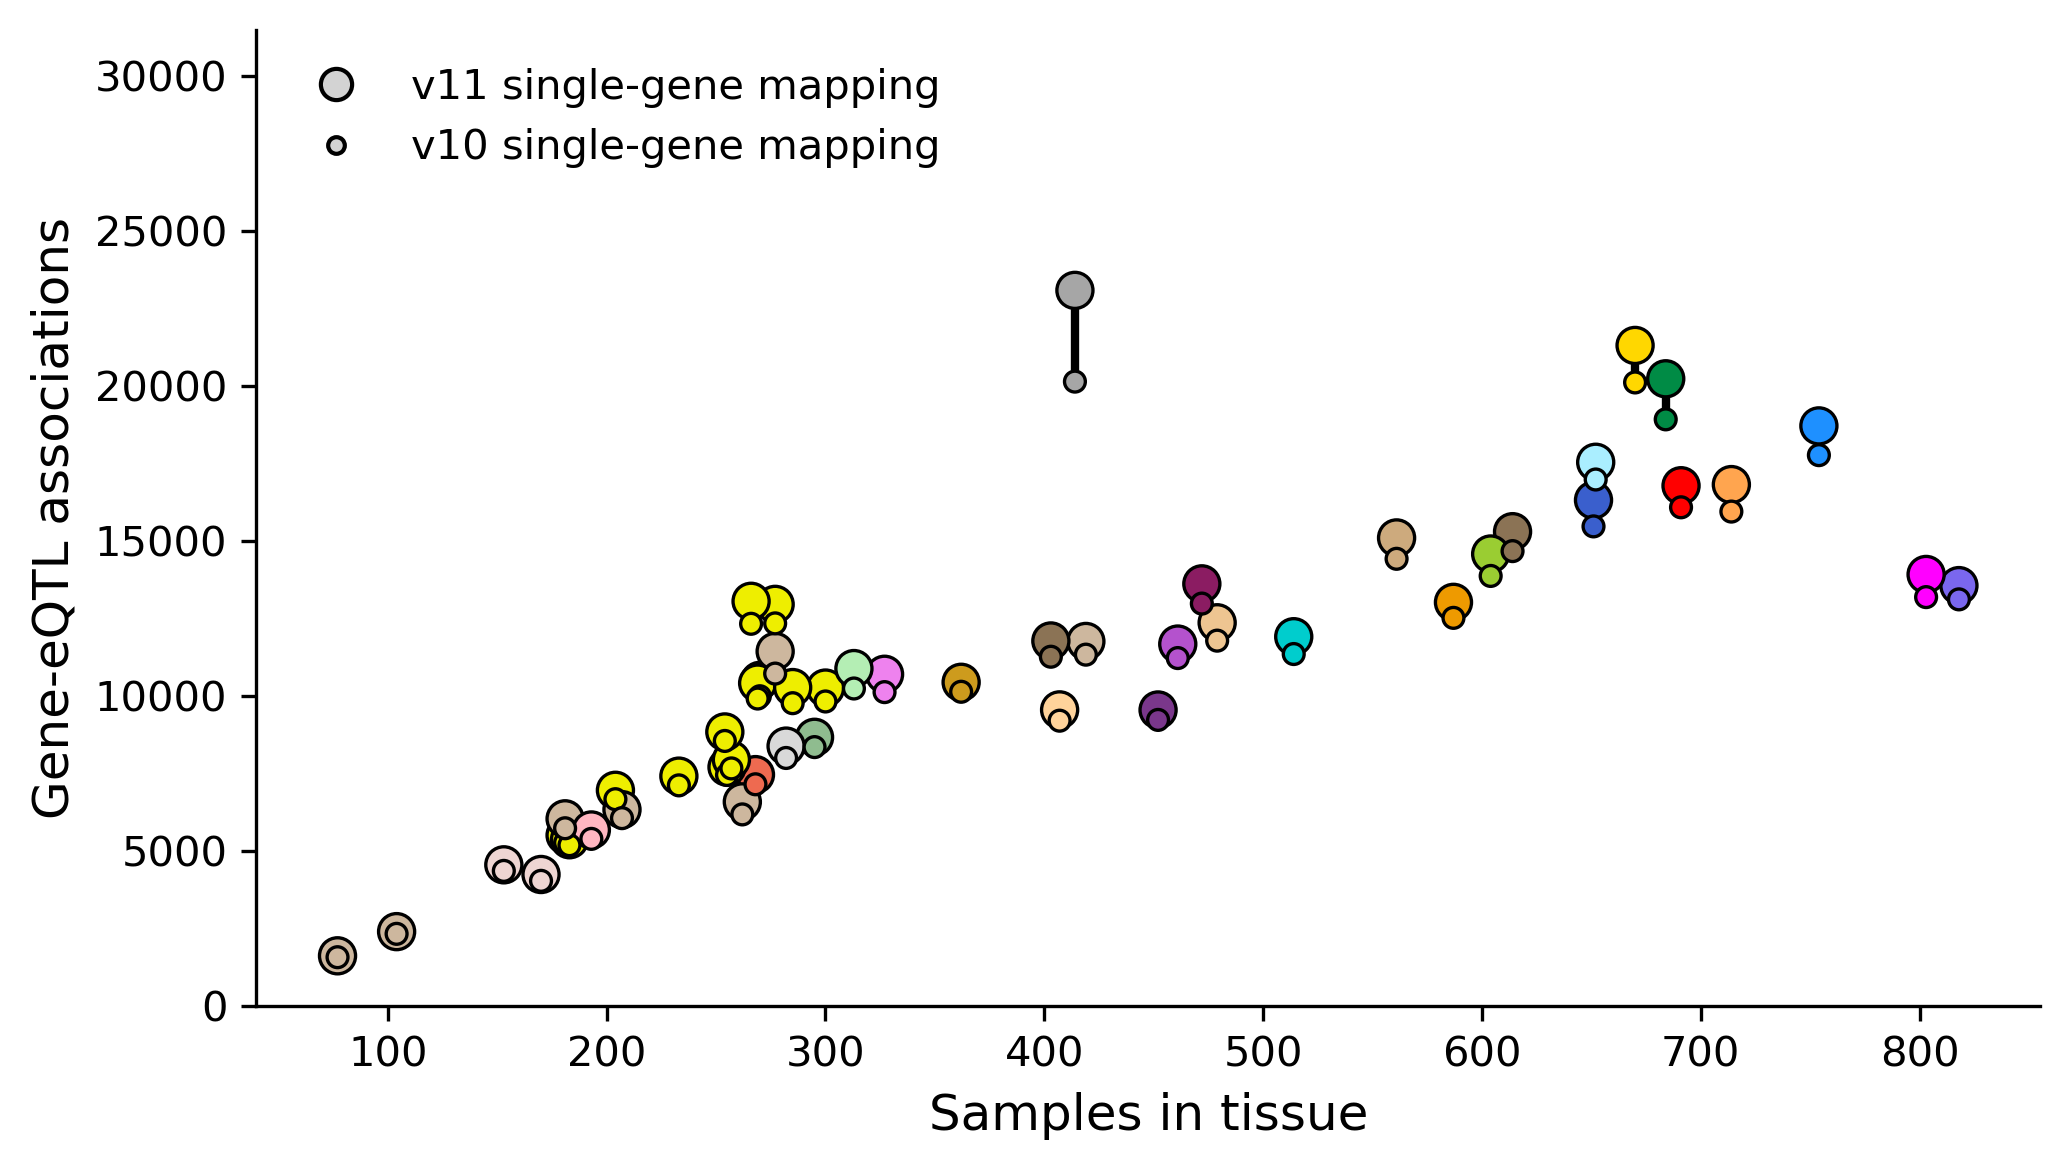

In [217]:
# Calculate the increase in number of loci for each tissue
increase_df = individual_loci[['tissue_id', 'num_samples', 'num_loci']].copy()
increase_df = increase_df.merge(
    v10_individual_loci[['tissue_id', 'num_loci']],
    on='tissue_id',
    suffixes=('_v11', '_v10')
)
increase_df['increase'] = increase_df['num_loci_v11'] - increase_df['num_loci_v10']

# Print the median increase
median_increase = increase_df['increase'].median()
print(f"Median increase in number of loci per tissue: {median_increase}")

# Create a single figure (no upper axis)
fig, ax = plt.subplots(figsize=(7, 4), dpi=300)

# Main scatter plot for v10 individual mapping
sns.scatterplot(
    data=v10_individual_loci,
    x='num_samples',
    y='num_loci',
    legend=False,
    hue='tissue_id',
    palette=tissue_color_map,
    edgecolor='black',
    linewidth=0.8,
    s=100,
    marker='.',
    zorder=3,
    ax=ax
)

# Main scatter plot for new individual mapping
sns.scatterplot(
    data=individual_loci,
    x='num_samples',
    y='num_loci',
    legend=False,
    hue='tissue_id',
    palette=tissue_color_map,
    edgecolor='black',
    linewidth=0.8,
    s=300,
    marker='.',
    zorder=2,
    ax=ax
)

# Draw lines connecting each tissue's individual and v10 individual points
for _, row in individual_loci.iterrows():
    tissue = row['tissue_id']
    v10_row = v10_individual_loci[v10_individual_loci['tissue_id'] == tissue]
    if v10_row.empty:
        continue
    v10_row = v10_row.iloc[0]
    x = row['num_samples']
    y_indiv = row['num_loci']
    y_v10 = v10_row['num_loci']
    line_color = 'black'
    ax.plot([x, x], [y_v10, y_indiv], color=line_color, linewidth=2, zorder=1)

ax.set_ylabel('Gene-eQTL associations', fontsize=12)
ax.set_xlabel('Samples in tissue', fontsize=12)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Custom legend for point types
import matplotlib.lines as mlines
v11_dot = mlines.Line2D([], [], color='black', marker='.', linestyle='None',
                        markersize=15, markerfacecolor='lightgrey', label='v11 single-gene mapping')
v10_dot = mlines.Line2D([], [], color='black', marker='.', linestyle='None',
                    markersize=8, markerfacecolor='lightgrey', label='v10 single-gene mapping')
ax.legend(handles=[v11_dot, v10_dot], loc='upper left', frameon=False)
ax.set_ylim(0, 31500)
plt.tight_layout()
plt.show()


Median increase in number of loci per tissue: 475.0


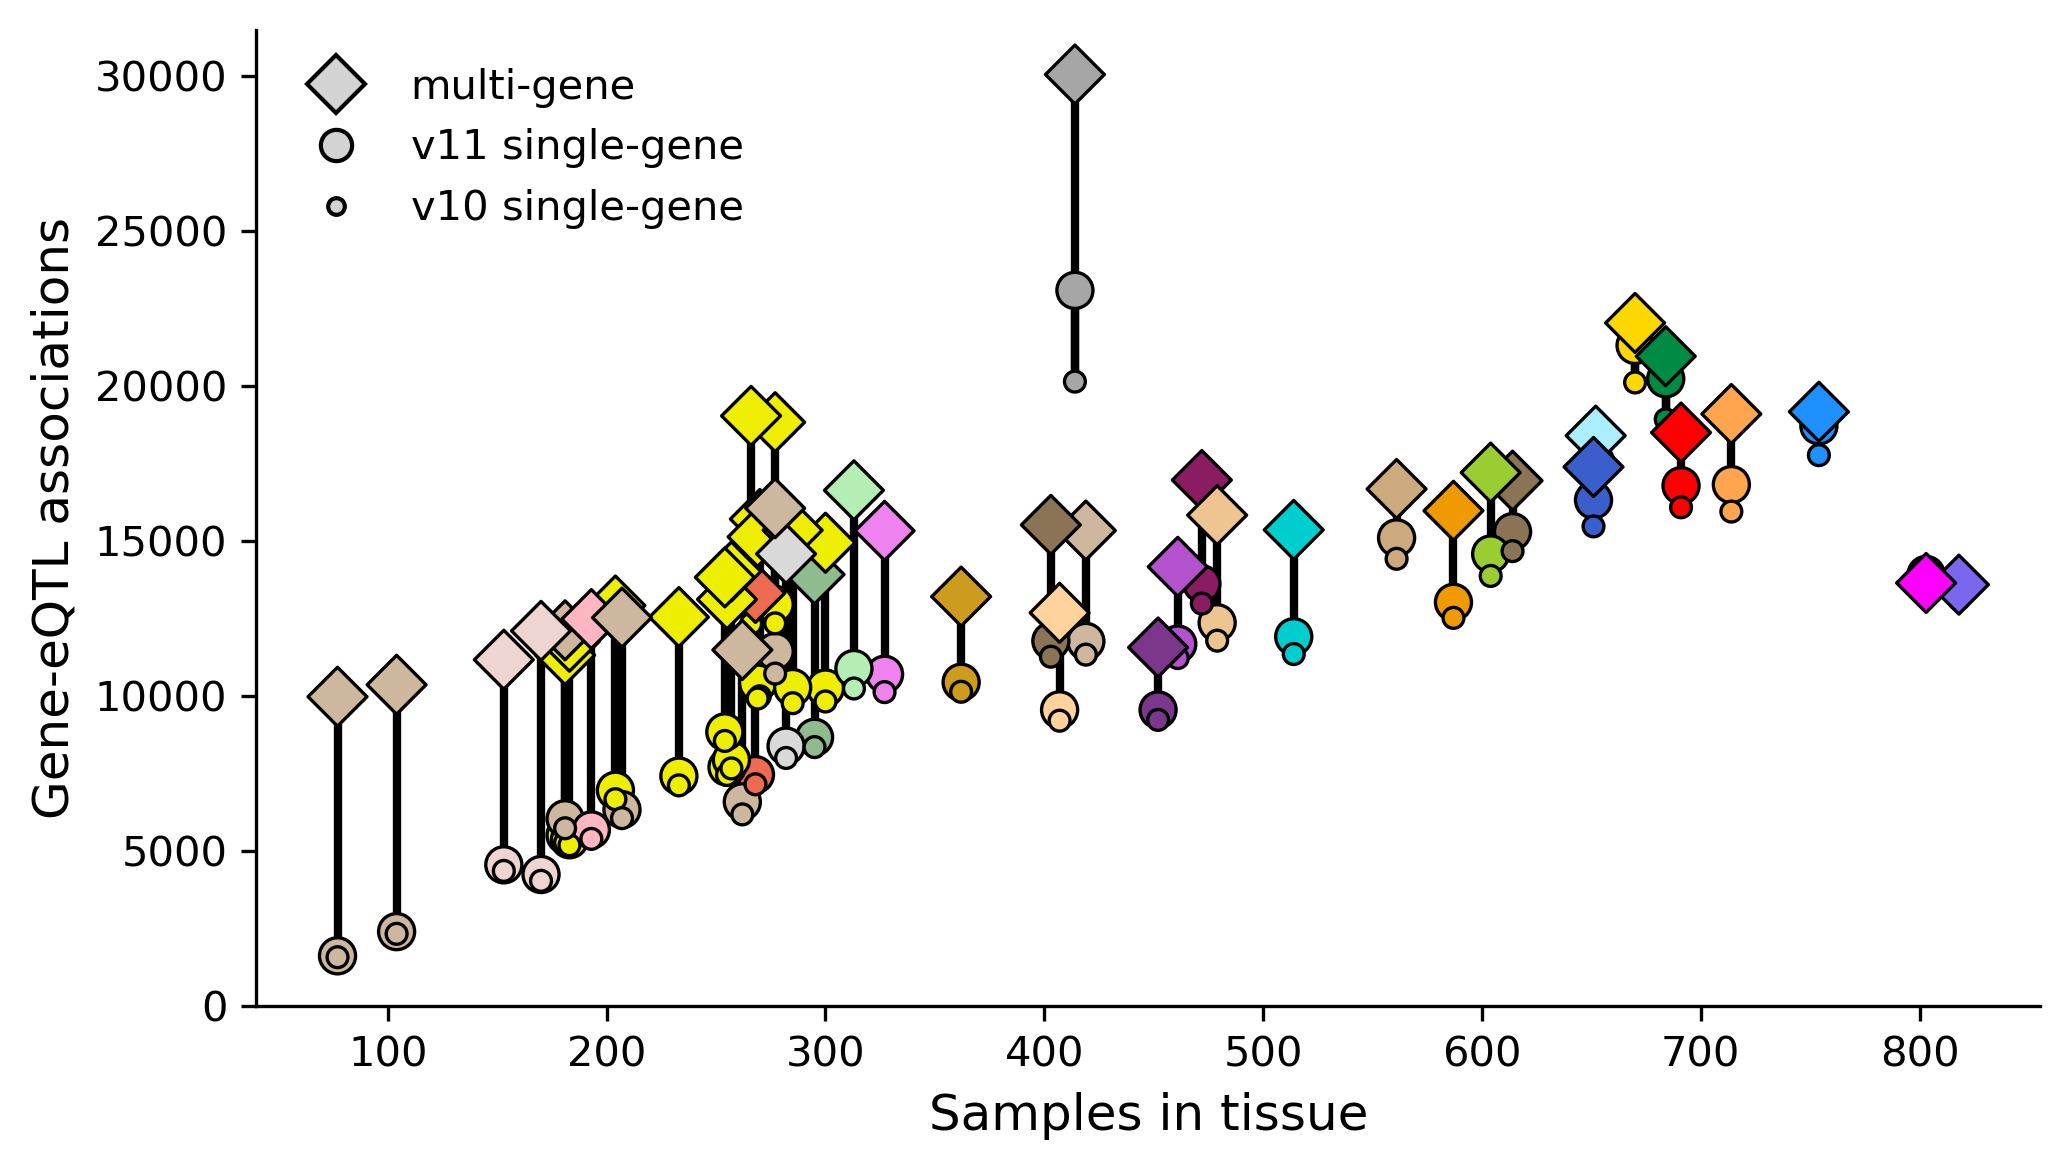

In [239]:
# Calculate the increase in number of loci for each tissue
increase_df = individual_loci[['tissue_id', 'num_samples', 'num_loci']].copy()
increase_df = increase_df.merge(
    v10_individual_loci[['tissue_id', 'num_loci']],
    on='tissue_id',
    suffixes=('_v11', '_v10')
)
increase_df['increase'] = increase_df['num_loci_v11'] - increase_df['num_loci_v10']

# Print the median increase
median_increase = increase_df['increase'].median()
print(f"Median increase in number of loci per tissue: {median_increase}")

# Create a single figure (no upper axis)
fig, ax = plt.subplots(figsize=(7, 4), dpi=300)

# Main scatter plot for v10 individual mapping
sns.scatterplot(
    data=v10_individual_loci,
    x='num_samples',
    y='num_loci',
    legend=False,
    hue='tissue_id',
    palette=tissue_color_map,
    edgecolor='black',
    linewidth=0.8,
    s=100,
    marker='.',
    zorder=3,
    ax=ax
)

# Main scatter plot for new individual mapping
sns.scatterplot(
    data=individual_loci,
    x='num_samples',
    y='num_loci',
    legend=False,
    hue='tissue_id',
    palette=tissue_color_map,
    edgecolor='black',
    linewidth=0.8,
    s=300,
    marker='.',
    zorder=2,
    ax=ax
)

# Add colocboost results as diamonds and lines from v10 to colocboost

sns.scatterplot(
    data=colocboost_loci,
    x='num_samples',
    y='num_gene_cs',  # Use num_gene_cs for colocboost_loci
    legend=False,
    hue='tissue_id',
    palette=tissue_color_map,
    edgecolor='black',
    linewidth=0.8,
    s=100,
    marker='D',
    zorder=4,
    ax=ax
)
# Draw lines from v10 to colocboost for each tissue
for _, row in colocboost_loci.iterrows():
    tissue = row['tissue_id']
    v10_row = v10_individual_loci[v10_individual_loci['tissue_id'] == tissue]
    if v10_row.empty:
        continue
    v10_row = v10_row.iloc[0]
    x = row['num_samples']
    y_colocboost = row['num_gene_cs']  # Use num_gene_cs for colocboost_loci
    y_v10 = v10_row['num_loci']
    line_color = 'k'
    ax.plot([x, x], [y_v10, y_colocboost], color=line_color, linewidth=2, zorder=1)

# Draw lines connecting each tissue's individual and v10 individual points
for _, row in individual_loci.iterrows():
    tissue = row['tissue_id']
    v10_row = v10_individual_loci[v10_individual_loci['tissue_id'] == tissue]
    if v10_row.empty:
        continue
    v10_row = v10_row.iloc[0]
    x = row['num_samples']
    y_indiv = row['num_loci']
    y_v10 = v10_row['num_loci']
    line_color = 'black'
    ax.plot([x, x], [y_v10, y_indiv], color=line_color, linewidth=2, zorder=1)

ax.set_ylabel('Gene-eQTL associations', fontsize=12)
ax.set_xlabel('Samples in tissue', fontsize=12)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Custom legend for point types
import matplotlib.lines as mlines
v11_dot = mlines.Line2D([], [], color='black', marker='.', linestyle='None',
                        markersize=15, markerfacecolor='lightgrey', label='v11 single-gene')
v10_dot = mlines.Line2D([], [], color='black', marker='.', linestyle='None',
                    markersize=8, markerfacecolor='lightgrey', label='v10 single-gene')
colocboost_diamond = mlines.Line2D([], [], color='black', marker='D', linestyle='None',
                                   markersize=10, markerfacecolor='lightgrey', label='multi-gene')
legend_handles = [colocboost_diamond, v11_dot, v10_dot]
ax.legend(handles=legend_handles, loc='upper left', frameon=False)
ax.set_ylim(0, 31500)
plt.tight_layout()
plt.show()


In [240]:
v39_coloc_dfs = get_coloc_dfs(tissue_df['tissue_file_name'].unique(), "/oak/stanford/groups/smontgom/dnachun/data/gtex/v10/output/coloc/single_tissue_qtl_only/0_first_pass_coloc_agg", file_name="v39")
v39_coloc_dfs

File not found for tissue_id: Artery_Femoral
File not found for tissue_id: Cervix_Ectocervix
File not found for tissue_id: Cervix_Endocervix
File not found for tissue_id: Fallopian_Tube
File not found for tissue_id: Kidney_Medulla
File not found for tissue_id: Stomach_Mixed_Cell
File not found for tissue_id: Stomach_Mucosa
File not found for tissue_id: Stomach_Muscularis


,phenotype_id,variant_id,pip,neg_log10_p_value,cs_id,cs_type,cos_npc,source_file,tissue_id,ld_block
0,Adipose_Subcutaneous.ENSG00000168672.4,chr8:126496993:G:A:b38,0.204798,22.5171,ucos10:y19,trait_specific,NaN,/oak/stanford/groups/smontgom/dnachun/data/gte...,Adipose_Subcutaneous,chr8:125397973-127646000
1,Adipose_Subcutaneous.ENSG00000168672.4,chr8:126498453:GA:G:b38,0.204798,22.5171,ucos10:y19,trait_specific,NaN,/oak/stanford/groups/smontgom/dnachun/data/gte...,Adipose_Subcutaneous,chr8:125397973-127646000
2,Adipose_Subcutaneous.ENSG00000168672.4,chr8:126498928:G:A:b38,0.204798,22.5171,ucos10:y19,trait_specific,NaN,/oak/stanford/groups/smontgom/dnachun/data/gte...,Adipose_Subcutaneous,chr8:125397973-127646000
3,Adipose_Subcutaneous.ENSG00000168672.4,chr8:126499617:A:G:b38,0.204798,22.5171,ucos10:y19,trait_specific,NaN,/oak/stanford/groups/smontgom/dnachun/data/gte...,Adipose_Subcutaneous,chr8:125397973-127646000
4,Adipose_Subcutaneous.ENSG00000168672.4,chr8:126501105:T:C:b38,0.054111,21.5869,ucos10:y19,trait_specific,NaN,/oak/stanford/groups/smontgom/dnachun/data/gte...,Adipose_Subcutaneous,chr8:125397973-127646000
...,...,...,...,...,...,...,...,...,...,...
124017,"Whole_Blood.ENSG00000129245.13,Whole_Blood.ENS...",chr17:7591027:CTCT:C:b38,0.021219,"7.46292, 12.7469",cos16:y56_y57,trait_shared,0.9132,/oak/stanford/groups/smontgom/dnachun/data/gte...,Whole_Blood,chr17:6730776-8996563
124018,"Whole_Blood.ENSG00000129245.13,Whole_Blood.ENS...",chr17:7617969:AG:A:b38,0.020485,"7.13291, 13.1098",cos16:y56_y57,trait_shared,0.9132,/oak/stanford/groups/smontgom/dnachun/data/gte...,Whole_Blood,chr17:6730776-8996563
124019,"Whole_Blood.ENSG00000129245.13,Whole_Blood.ENS...",chr17:7622230:C:G:b38,0.020485,"7.13291, 13.1098",cos16:y56_y57,trait_shared,0.9132,/oak/stanford/groups/smontgom/dnachun/data/gte...,Whole_Blood,chr17:6730776-8996563
124020,"Whole_Blood.ENSG00000129245.13,Whole_Blood.ENS...",chr17:7600742:G:C:b38,0.017578,"7.57051, 12.2979",cos16:y56_y57,trait_shared,0.9132,/oak/stanford/groups/smontgom/dnachun/data/gte...,Whole_Blood,chr17:6730776-8996563


In [241]:
v39_coloc_dfs['gene_id'] = v39_coloc_dfs['phenotype_id'].str.split(',')
v39_coloc_dfs['p_value'] = v39_coloc_dfs['neg_log10_p_value'].str.split(', ')
v39_coloc_exploded = v39_coloc_dfs.drop_duplicates(subset=['phenotype_id', 'cs_id', 'tissue_id', 'ld_block']).explode(['gene_id', 'p_value'])

In [242]:
# count the number of credible sets (double counting if multiple genes, equivilent to single gene model)
v39_gene_qtl_counts = v39_coloc_exploded['tissue_id'].value_counts().sort_index()
v39_gene_qtl_counts = v39_gene_qtl_counts.reset_index()
v39_gene_qtl_counts.columns = ['tissue_id', 'num_gene_cs']
v39_gene_qtl_counts = pd.merge(v39_gene_qtl_counts,
    num_samples[['tissue_file_name', 'tissue_abbrv', 'num_samples']],
    left_on='tissue_id',
    right_on='tissue_file_name',
    how='left'
)

In [245]:
v39_gene_qtl_counts.head()

,tissue_id,num_gene_cs,tissue_file_name,tissue_abbrv,num_samples
0,Adipose_Subcutaneous,16531,Adipose_Subcutaneous,ADPSBQ,714
1,Adipose_Visceral_Omentum,13857,Adipose_Visceral_Omentum,ADPVSC,587
2,Adrenal_Gland,11856,Adrenal_Gland,ADRNLG,295
3,Artery_Aorta,14707,Artery_Aorta,ARTAORT,472
4,Artery_Coronary,11206,Artery_Coronary,ARTCRN,268


Median increase in number of loci per tissue: 475.0


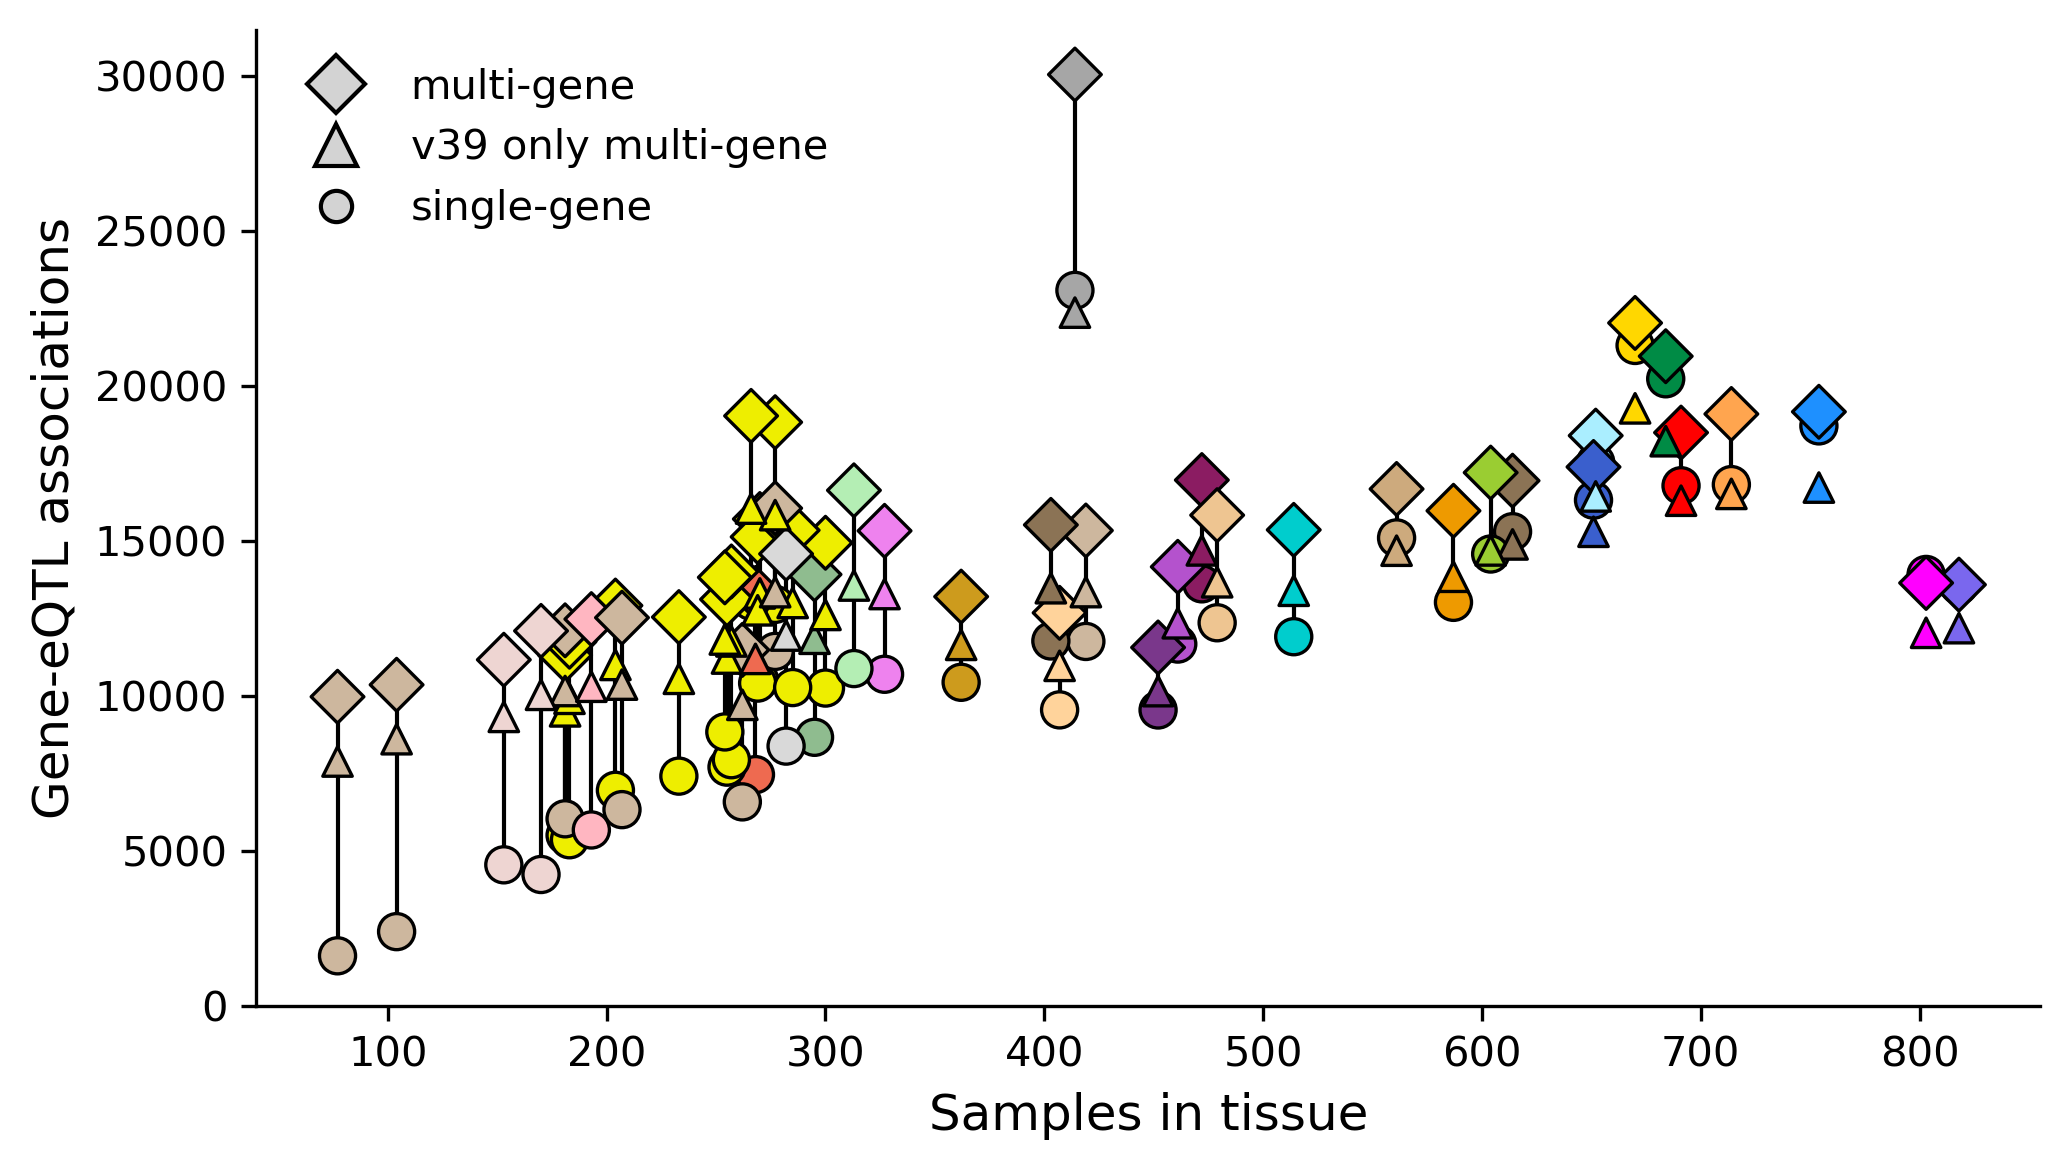

In [258]:
# Calculate the increase in number of loci for each tissue
increase_df = individual_loci[['tissue_id', 'num_samples', 'num_loci']].copy()
increase_df = increase_df.merge(
    v10_individual_loci[['tissue_id', 'num_loci']],
    on='tissue_id',
    suffixes=('_v11', '_v10')
)
increase_df['increase'] = increase_df['num_loci_v11'] - increase_df['num_loci_v10']

# Print the median increase
median_increase = increase_df['increase'].median()
print(f"Median increase in number of loci per tissue: {median_increase}")

# Create a single figure (no upper axis)
fig, ax = plt.subplots(figsize=(7, 4), dpi=300)

# Main scatter plot for new individual mapping (v11 single-gene)
sns.scatterplot(
    data=individual_loci,
    x='num_samples',
    y='num_loci',
    legend=False,
    hue='tissue_id',
    palette=tissue_color_map,
    edgecolor='black',
    linewidth=0.8,
    s=300,
    marker='.',
    zorder=2,
    ax=ax
)

# Add colocboost results as diamonds
sns.scatterplot(
    data=colocboost_loci,
    x='num_samples',
    y='num_gene_cs',  # Use num_gene_cs for colocboost_loci
    legend=False,
    hue='tissue_id',
    palette=tissue_color_map,
    edgecolor='black',
    linewidth=0.8,
    s=80,
    marker='D',
    zorder=4,
    ax=ax
)

# Add v39_gene_qtl_counts as triangles
sns.scatterplot(
    data=v39_gene_qtl_counts,
    x='num_samples',
    y='num_gene_cs',
    legend=False,
    hue='tissue_id',
    palette=tissue_color_map,
    edgecolor='black',
    linewidth=0.8,
    s=50,
    marker='^',
    zorder=5,
    ax=ax
)

# Draw lines from v11 single-gene to colocboost for each tissue
for _, row in colocboost_loci.iterrows():
    tissue = row['tissue_id']
    v11_row = individual_loci[individual_loci['tissue_id'] == tissue]
    if v11_row.empty:
        continue
    v11_row = v11_row.iloc[0]
    x = row['num_samples']
    y_colocboost = row['num_gene_cs']  # Use num_gene_cs for colocboost_loci
    y_v11 = v11_row['num_loci']
    line_color = 'k'
    ax.plot([x, x], [y_v11, y_colocboost], color=line_color, linewidth=1, zorder=1)

ax.set_ylabel('Gene-eQTL associations', fontsize=12)
ax.set_xlabel('Samples in tissue', fontsize=12)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Custom legend for point types (no v10 single-gene)
import matplotlib.lines as mlines
v11_dot = mlines.Line2D([], [], color='black', marker='.', linestyle='None',
                        markersize=15, markerfacecolor='lightgrey', label='single-gene')
colocboost_diamond = mlines.Line2D([], [], color='black', marker='D', linestyle='None',
                                   markersize=10, markerfacecolor='lightgrey', label='multi-gene')
v39_triangle = mlines.Line2D([], [], color='black', marker='^', linestyle='None',
                             markersize=10, markerfacecolor='lightgrey', label='v39 only multi-gene')
legend_handles = [colocboost_diamond, v39_triangle, v11_dot]
ax.legend(handles=legend_handles, loc='upper left', frameon=False)
ax.set_ylim(0, 31500)
plt.tight_layout()
plt.show()


In [264]:
# No data available for plotting. Check input DataFrames for missing or mismatched tissue IDs.
print("No data available for plotting. Check input DataFrames for missing or mismatched tissue IDs.")


No data available for plotting. Check input DataFrames for missing or mismatched tissue IDs.


### QTL-gene ve unique loci

<Axes: xlabel='num_genes', ylabel='Count'>

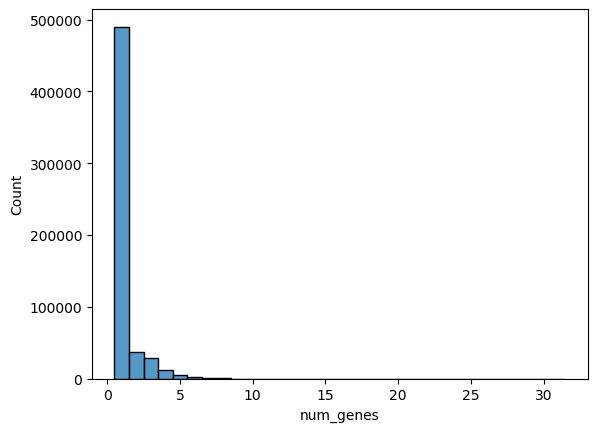

In [272]:
sns.histplot(all_coloc_strong_annotated, x='num_genes', discrete=True)

In [268]:
colocboost_loci = pd.merge(all_coloc_strong_annotated['tissue_id'].value_counts().sort_index(), colocboost_loci, on='tissue_id', how='left')
colocboost_loci.head()

,tissue_id,count,num_coloc_loci,num_coloc_loci,num_gene_cs,tissue_file_name,tissue_abbrv,num_samples
0,Adipose_Subcutaneous,14068,14068,14068,19109,Adipose_Subcutaneous,ADPSBQ,714
1,Adipose_Visceral_Omentum,12033,12033,12033,15986,Adipose_Visceral_Omentum,ADPVSC,587
2,Adrenal_Gland,10722,10722,10722,13931,Adrenal_Gland,ADRNLG,295
3,Artery_Aorta,12654,12654,12654,16977,Artery_Aorta,ARTAORT,472
4,Artery_Coronary,10441,10441,10441,13334,Artery_Coronary,ARTCRN,268


<Axes: xlabel='num_gene_cs', ylabel='count'>

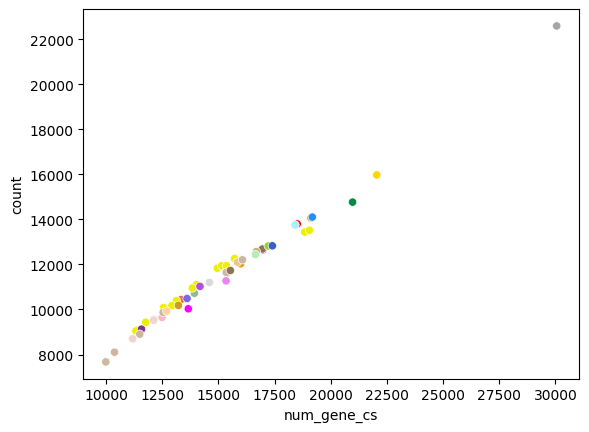

In [269]:
sns.scatterplot(colocboost_loci, x='num_gene_cs', y='count', hue='tissue_id', palette=tissue_color_map, legend=False)

In [ ]:
# count the number of credible sets (double counting if multiple genes, equivilent to single gene model)
total_gene_qtl_counts = all_coloc_exploded['tissue_id'].value_counts().sort_index()
total_gene_qtl_counts = total_gene_qtl_counts.reset_index()
total_gene_qtl_counts.columns = ['tissue_id', 'num_gene_cs']
colocboost_loci = pd.merge(total_gene_qtl_counts,
    num_samples[['tissue_file_name', 'tissue_abbrv', 'num_samples']],
    left_on='tissue_id',
    right_on='tissue_file_name',
    how='left'
)

In [ ]:
fig, ax = plt.subplots(figsize=(9, 5))

# Vertical barplot: tissue on x axis, number of loci on y axis
# Stacked barplot: new_lncRNA on top of existing_lncRNA for each tissue
sns.barplot(
    data=increase_df,
    x='tissue_abbrv',
    y='num_loci',
    ax=ax, 
    color='#b70657',
    alpha=0.7
)

ax.set_ylabel('New-lncRNA-specific loci', fontsize=12)
ax.set_xlabel('')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Add horizontal grid lines
ax.yaxis.grid(True, which='major', linestyle='--', linewidth=0.7, color='gray', alpha=0.5)
ax.set_axisbelow(True)

# # Add number at the top of the bar for each tissue if nonzero
# for i, (num, tissue_abbrv) in enumerate(zip(bar_df['num_loci'], bar_df['tissue_abbrv'])):
#     if num > 0:
#         ax.text(i, num + 0.5, f"{int(num)}", va='bottom', ha='center', fontsize=10)

# Add colored dots below the x axis for each tissue
xticklabels = [item.get_text() for item in ax.get_xticklabels()]
xticks = ax.get_xticks()
ax.tick_params(axis='x', pad=10, rotation=90)
x_positions = np.array(xticks)
for x, tissue_abbrv in zip(x_positions, xticklabels):
    tissue_id = bar_df.loc[bar_df['tissue_abbrv'] == tissue_abbrv, 'tissue_id'].values[0]
    color = tissue_color_map.get(tissue_id, "#888888")
    circle = patches.Ellipse(
        (x, -0.05 * ax.get_ylim()[1]), width=0.6, height=0.03 * ax.get_ylim()[1],
        transform=ax.transData,
        color=color, clip_on=False
    )
    ax.add_patch(circle)

plt.subplots_adjust(bottom=0.35)
plt.show()

In [ ]:
lead_variant_cols = [
    'tissue_id', 'phenotype_id', 'cs_id', 'variant_id', 'biotype',
]

# Calculate the number of unique variants in each credible set (per tissue, phenotype, cs_id)
cs_variant_counts = (
    esusie_df
    .groupby(['tissue_id', 'phenotype_id', 'cs_id'])['variant_id']
    .nunique()
    .reset_index()
    .rename(columns={'variant_id': 'num_cs_variants'})
)

# Get the lead variant for each credible set
susie_lead_variant_df = (
    esusie_df
    .sort_values('pip', ascending=False)
    .groupby(['tissue_id', 'phenotype_id', 'cs_id'], as_index=False)
    .first()[lead_variant_cols]
    .rename(columns={'variant_id': 'lead_variant_id'})
)

# Merge the number of unique variants in the credible set into the lead variant dataframe
susie_lead_variant_df = susie_lead_variant_df.merge(
    cs_variant_counts,
    on=['tissue_id', 'phenotype_id', 'cs_id'],
    how='left'
)

lead_shared = susie_lead_variant_df.groupby(['tissue_id', 'lead_variant_id']).agg({'phenotype_id': list, 'biotype': list})

In [ ]:
# Count total number of loci per tissue using lead_shared
total_loci_counts = lead_shared.reset_index().groupby('tissue_id')['lead_variant_id'].nunique().sort_index()
lead_shared_individual_loci = total_loci_counts.reset_index()
lead_shared_individual_loci.columns = ['tissue_id', 'num_loci']

# Merge with tissue_df to get tissue_abbrv for x-ticks
lead_shared_individual_loci = lead_shared_individual_loci.merge(
    tissue_df[['tissue_file_name', 'tissue_abbrv']],
    left_on='tissue_id',
    right_on='tissue_file_name',
    how='left'
)

In [ ]:
# Scatter plot: number of samples per tissue vs number of loci for both lead shared individual and colocboost joint loci

# Prepare data for scatter plot
# Merge lead_shared_individual_loci (individual model) and bar_df (joint model) with num_samples
# lead_shared_scatter = lead_shared_individual_loci.merge(
#     num_samples,
#     left_on='tissue_file_name',
#     right_on='tissue_file_name',
#     how='left'
# )
# lead_shared_scatter['model'] = 'Lead shared individual'

individual_loci_scatter = individual_loci.merge(
    num_samples,
    left_on='tissue_file_name',
    right_on='tissue_file_name',
    how='left'
)
individual_loci_scatter['model'] = 'All individual'


colocboost_scatter = colocboost_joint_loci.merge(
    num_samples,
    left_on='tissue_file_name',
    right_on='tissue_file_name',
    how='left'
)
colocboost_scatter['model'] = 'Colocboost joint'

# Concatenate for plotting
scatter_df = pd.concat([individual_loci_scatter, colocboost_scatter], ignore_index=True)

plt.figure(figsize=(7, 5))
sns.scatterplot(
    data=scatter_df,
    x='num_samples',
    y='num_loci',
    hue='model',
    palette={'All individual': '#1f77b4', 'Colocboost joint': '#b70657'},
    s=80
)
plt.xlabel('Number of samples in tissue')
plt.ylabel('Number of loci')
plt.title('Number of loci vs number of samples per tissue')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


In [ ]:
# what proprtion of esusie leads are in the joint?

# get all joint coloc loci, exploded to individual gene ids
all_coloc_dfs['gene_id'] = all_coloc_dfs['phenotype_id'].str.split(',')
all_coloc_full_exploded = all_coloc_dfs.explode('gene_id')
all_coloc_full_exploded['gene_id_stable'] = all_coloc_full_exploded['gene_id'].str.split('.').str[1]

# match up susie leads to joint coloc loci
susie_lead_variant_df['gene_id_stable'] = susie_lead_variant_df['phenotype_id'].str.split('.').str[0]
susie_lead_variant_df['colocboost_format_variant_id'] = susie_lead_variant_df['lead_variant_id'].str.replace('_', ':')
susie_lead_variant_joint_annotated = pd.merge(
    susie_lead_variant_df,  
    all_coloc_full_exploded[['tissue_id', 'gene_id_stable', 'variant_id', 'phenotype_id', 'cs_id', 'cs_type', 'num_cs_variants']],
    left_on=['tissue_id', 'gene_id_stable', 'colocboost_format_variant_id'],
    right_on=['tissue_id', 'gene_id_stable', 'variant_id'],
    how='left',
    suffixes=['_individual', '_joint']
).reset_index()
susie_lead_variant_joint_annotated['in_joint'] = ~susie_lead_variant_joint_annotated['phenotype_id_joint'].isna()

In [ ]:
sns.swarmplot(susie_lead_variant_joint_annotated.groupby('tissue_id')['in_joint'].mean().reset_index(), hue='tissue_id', y='in_joint', palette=tissue_color_map, legend=False)

In [ ]:
lead_in_both = susie_lead_variant_joint_annotated[susie_lead_variant_joint_annotated['in_joint']]
lead_in_both['cs_diff'] = lead_in_both['num_cs_variants_joint'] - lead_in_both['num_cs_variants_individual']

sns.histplot(lead_in_both, x='cs_diff',bins=np.arange(-10, 10.5, 0.5))

In [ ]:
# what proportion of an susie overlap with a cs (any varint, not jsut lead)
# match up susie leads to joint coloc loci
esusie_df['gene_id_stable'] = esusie_df['phenotype_id'].str.split('.').str[0]
esusie_df['colocboost_format_variant_id'] = esusie_df['variant_id'].str.replace('_', ':')
susie_any_variant_joint_annotated = pd.merge(
    esusie_df,  
    all_coloc_full_exploded[['tissue_id', 'gene_id_stable', 'variant_id', 'phenotype_id', 'cs_id', 'cs_type', 'num_cs_variants']],
    left_on=['tissue_id', 'gene_id_stable', 'colocboost_format_variant_id'],
    right_on=['tissue_id', 'gene_id_stable', 'variant_id'],
    how='left',
    suffixes=['_individual', '_joint']
).reset_index()
susie_any_variant_joint_annotated['in_joint'] = ~susie_any_variant_joint_annotated['phenotype_id_joint'].isna()

In [ ]:
# group into credible sets
susie_any_variant_joint_cs_grouped = susie_any_variant_joint_annotated.groupby(['tissue_id', 'phenotype_id_individual', 'cs_id_individual']).agg({'in_joint': 'any', 'phenotype_id_joint':'unique'}).reset_index()

In [ ]:
sns.swarmplot(susie_any_variant_joint_cs_grouped.groupby('tissue_id')['in_joint'].mean().reset_index(), hue='tissue_id', y='in_joint', palette=tissue_color_map, legend=False)


In [ ]:
# Identify loci where all gene types are 'new_lncRNA'
only_new_lncRNA = all_coloc_annotated[
    all_coloc_annotated['gene_type_grouped_highlight'].apply(
        lambda x: all(gt == "new_lncRNA" for gt in x if pd.notnull(gt))
    )
]

# Count number of such loci per tissue
only_new_lncRNA_counts = only_new_lncRNA['tissue_id'].value_counts().sort_index()
bar_df = only_new_lncRNA_counts.reset_index()
bar_df.columns = ['tissue_id', 'num_loci']

# Merge with tissue_df to get tissue_abbrv for x-ticks
bar_df = bar_df.merge(
    tissue_df[['tissue_file_name', 'tissue_abbrv']],
    left_on='tissue_id',
    right_on='tissue_file_name',
    how='left'
)
# bar_df = bar_df.sort_values('num_loci', ascending=False)

fig, ax = plt.subplots(figsize=(9, 5))

# Vertical barplot: tissue on x axis, number of loci on y axis
sns.barplot(
    data=bar_df,
    x='tissue_abbrv',
    y='num_loci',
    color='#b70657',
    ax=ax
)

ax.set_ylabel('New lncRNA specific loci', fontsize=12)
ax.set_xlabel('')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Add horizontal grid lines
ax.yaxis.grid(True, which='major', linestyle='--', linewidth=0.7, color='gray', alpha=0.5)
ax.set_axisbelow(True)

# # Add number at the top of the bar for each tissue if nonzero
# for i, (num, tissue_abbrv) in enumerate(zip(bar_df['num_loci'], bar_df['tissue_abbrv'])):
#     if num > 0:
#         ax.text(i, num + 0.5, f"{int(num)}", va='bottom', ha='center', fontsize=10)

# Add colored dots below the x axis for each tissue
xticklabels = [item.get_text() for item in ax.get_xticklabels()]
xticks = ax.get_xticks()
ax.tick_params(axis='x', pad=10, rotation=90)
x_positions = np.array(xticks)
for x, tissue_abbrv in zip(x_positions, xticklabels):
    tissue_id = bar_df.loc[bar_df['tissue_abbrv'] == tissue_abbrv, 'tissue_id'].values[0]
    color = tissue_color_map.get(tissue_id, "#888888")
    circle = patches.Ellipse(
        (x, -0.05 * ax.get_ylim()[1]), width=0.6, height=0.03 * ax.get_ylim()[1],
        transform=ax.transData,
        color=color, clip_on=False
    )
    ax.add_patch(circle)

plt.subplots_adjust(bottom=0.35)
plt.show()

In [ ]:
bar_df['num_loci'].median()

In [ ]:
bar_df['num_loci'].sum()

In [ ]:
# Categorize loci by new_lncRNA status
def locus_category(gene_types):
    gene_types = [gt for gt in gene_types if pd.notnull(gt)]
    if all(gt == "new_lncRNA" for gt in gene_types):
        return "only_new_lncRNA"
    elif any(gt == "new_lncRNA" for gt in gene_types):
        return "mixed_with_new_lncRNA"
    else:
        return "no_new_lncRNA"

all_coloc_annotated['locus_category'] = all_coloc_annotated['gene_type_grouped_highlight'].apply(locus_category)

In [ ]:
# Recreate combined_summary: summarize proxitropy by tissue and biotype
# Assign biotype membership for each locus: a locus can belong to both 'protein_coding' and 'lncRNA' if it contains both types
def get_biotype_memberships(gene_types):
    gene_types = [gt for gt in gene_types if pd.notnull(gt)]
    memberships = []
    if any(gt == "protein_coding" for gt in gene_types):
        memberships.append("protein_coding")
    if any("lncRNA" in str(gt) for gt in gene_types):
        memberships.append("lncRNA")
    return memberships

# Expand loci so that each locus appears once for each biotype it belongs to
biotype_loci_expanded = all_coloc_annotated.copy()
biotype_loci_expanded['biotype'] = all_coloc_annotated['gene_type_grouped_highlight'].apply(get_biotype_memberships)
biotype_loci_expanded = biotype_loci_expanded.explode('biotype')
biotype_loci_expanded = biotype_loci_expanded[biotype_loci_expanded['biotype'].isin(['protein_coding', 'lncRNA'])]

# For each tissue and biotype, calculate mean proxitropy
combined_summary = (
    biotype_loci_expanded
    .groupby(['tissue_id', 'biotype'])
    .agg(proxitropy=('proxitropy', 'mean'))
    .reset_index()
)

combined_summary['percent_proxitropy'] = combined_summary['proxitropy'] * 100

fig, ax = plt.subplots(figsize=(6, 3))
sns.swarmplot(
    data=combined_summary,
    x='biotype',
    y='percent_proxitropy',
    hue='tissue_id',
    palette=tissue_color_map,
    legend=False,
    ax=ax, 
    linewidth=0.5,
    edgecolor='black'
)

sns.boxplot(
    data=combined_summary,
    x='biotype',
    y='percent_proxitropy',
    hue='biotype',
    palette={'protein_coding':'#016895', 'lncRNA':'#b70657'},
    legend=False,
    ax=ax, 
    boxprops=dict(alpha=0.7),
    showfliers=False
)

ax.set_ylabel('Proxitropy (%)')
ax.set_xlabel('')
ax.set_xticks(range(2))
#ax.set_xticklabels(['Protein coding', 'lncRNA'])
ax.set_ylim(0, 100)
sns.despine()
plt.show()

In [ ]:
# Combine 'mixed_with_new_lncRNA' and 'no_new_lncRNA' into a single 'other' category
all_coloc_annotated['locus_category_simple'] = all_coloc_annotated['locus_category'].replace(
    {'mixed_with_new_lncRNA': 'other', 'no_new_lncRNA': 'other'}
)

fig, ax = plt.subplots(figsize=(6, 3), dpi=600)
sns.histplot(
    all_coloc_annotated,
    x='num_genes',
    discrete=True,
    color='grey',
    stat='percent',
    hue='locus_category_simple',
    palette={'only_new_lncRNA': '#b70657', 'other': '#bbbbbb'},
    multiple='stack',
    hue_order=['only_new_lncRNA', 'other'],
    legend=False
)

sns.despine()
ax.set_xlim(0, 10)
ax.set_xticks(range(0, 11))
ax.set_xticklabels([*range(0, 10), '10+'])
ax.set_xlabel('Genes per QTL')
ax.set_ylabel('Percent of QTL')


plt.show()

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as patches

# Categorize loci by new_lncRNA status
def locus_category(gene_types):
    gene_types = [gt for gt in gene_types if pd.notnull(gt)]
    if all(gt == "new_lncRNA" for gt in gene_types):
        return "only_new_lncRNA"
    elif any(gt == "new_lncRNA" for gt in gene_types):
        return "mixed_with_new_lncRNA"
    else:
        return "no_new_lncRNA"

all_coloc_annotated['locus_category'] = all_coloc_annotated['gene_type_grouped_highlight'].apply(locus_category)

# Count number of loci per tissue and category
cat_counts = (
    all_coloc_annotated
    .groupby(['tissue_id', 'locus_category'])
    .size()
    .unstack(fill_value=0)
    .reset_index()
)

# Ensure all three columns exist
for col in ['only_new_lncRNA', 'mixed_with_new_lncRNA', 'no_new_lncRNA']:
    if col not in cat_counts.columns:
        cat_counts[col] = 0

# Merge with tissue_df to get tissue_abbrv for x-ticks
cat_counts = cat_counts.merge(
    tissue_df[['tissue_file_name', 'tissue_abbrv']],
    left_on='tissue_id',
    right_on='tissue_file_name',
    how='left'
)

# Sort by tissue_abbrv for consistent plotting
cat_counts = cat_counts.sort_values('tissue_abbrv')

fig, ax = plt.subplots(figsize=(7, 4))

# Stacked barplot: bottom=only_new_lncRNA (dark red), middle=mixed_with_new_lncRNA (green), top=no_new_lncRNA (grey)
bar_bottom = cat_counts['only_new_lncRNA']
bar_middle = cat_counts['mixed_with_new_lncRNA']
bar_top = cat_counts['no_new_lncRNA']

x = np.arange(len(cat_counts['tissue_abbrv']))

# Plot each layer
ax.bar(
    x,
    bar_bottom,
    color='#b70657',
    label='Only new lncRNA'
)
ax.bar(
    x,
    bar_middle,
    bottom=bar_bottom,
    color='#2ca02c',
    label='Mixed with new lncRNA'
)
ax.bar(
    x,
    bar_top,
    bottom=bar_bottom + bar_middle,
    color='#bbbbbb',
    label='No new lncRNA'
)

ax.set_xticks(x)
ax.set_xticklabels(cat_counts['tissue_abbrv'], rotation=90)
ax.set_ylabel('Number of loci', fontsize=12)
ax.set_xlabel('')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Add horizontal grid lines
ax.yaxis.grid(True, which='major', linestyle='--', linewidth=0.7, color='gray', alpha=0.5)
ax.set_axisbelow(True)

# Add colored dots below the x axis for each tissue
xticklabels = [item.get_text() for item in ax.get_xticklabels()]
xticks = ax.get_xticks()
ax.tick_params(axis='x', pad=10, rotation=90)
x_positions = np.array(xticks)
for x_pos, tissue_abbrv in zip(x_positions, cat_counts['tissue_abbrv']):
    tissue_id = cat_counts.loc[cat_counts['tissue_abbrv'] == tissue_abbrv, 'tissue_id'].values[0]
    color = tissue_color_map.get(tissue_id, "#888888")
    circle = patches.Ellipse(
        (x_pos, -0.05 * ax.get_ylim()[1]), width=0.4, height=0.02 * ax.get_ylim()[1],
        transform=ax.transData,
        color=color, clip_on=False
    )
    ax.add_patch(circle)

ax.legend(loc='upper right', fontsize=10, frameon=False)
plt.subplots_adjust(bottom=0.35)
plt.show()

In [ ]:
v39_coloc_dfs = get_coloc_dfs(tissue_df['tissue_file_name'].unique(), "/oak/stanford/groups/smontgom/dnachun/data/gtex/v10/output/coloc/single_tissue_qtl_only", file_name="v39")
v39_coloc_dfs

In [ ]:
def get_coloc_counts(tissue_id, gencode_ids, lncrna_order):
    """
    For a given tissue_id, load coloc result files, process lead variant gene types,
    and return a pivot DataFrame with counts of locus categories for each coloc method.
    """
    coloc_output_dir = f"/oak/stanford/groups/smontgom/dnachun/data/gtex/v10/output/coloc/single_tissue_qtl_only"

    # Load coloc result files
    v39_coloc_df = pd.read_table(f"{coloc_output_dir}/{tissue_id}.xqtl_coloc.v39.txt")
    v39_coloc_df['tissue_id'] = tissue_id
    v39_coloc_df['ld_block'] = v39_coloc_df['source_file'].str.split('/').str[-1].str.split('.').str[1]

    all_coloc_df = pd.read_table(f"{coloc_output_dir}/{tissue_id}.xqtl_coloc.all.txt")
    all_coloc_df['tissue_id'] = tissue_id
    all_coloc_df['ld_block'] = all_coloc_df['source_file'].str.split('/').str[-1].str.split('.').str[1]

    individual_coloc_df = pd.read_table(f"{coloc_output_dir}/{tissue_id}.xqtl_coloc.individual.txt")
    individual_coloc_df['tissue_id'] = tissue_id
    individual_coloc_df['ld_block'] = individual_coloc_df['source_file'].str.split('/').str[-1].str.split('.').str[1]

    lead_variant_cols = [
        'tissue_id', 'phenotype_id', 'cs_id', 'variant_id',
    ]

    # Individual
    individual_lead_variant_df = (
        individual_coloc_df
        .sort_values('pip', ascending=False)
        .groupby(['tissue_id', 'phenotype_id', 'cs_id', 'ld_block'], as_index=False)
        .first()[lead_variant_cols]
        .rename(columns={'variant_id': 'lead_variant_id'})
    )
    individual_lead_variant_df['gene_id_stable'] = individual_lead_variant_df['phenotype_id'].str.split('.').str[1]
    individual_lead_variant_df = pd.merge(
        individual_lead_variant_df, 
        gencode_ids[['gene_id_stable', 'gene_type_grouped_highlight']], 
        on='gene_id_stable', 
        how='left')
    individual_lead_grouped = individual_lead_variant_df.groupby(
        ['tissue_id', 'lead_variant_id']
    ).agg({
        'phenotype_id': list, 
        'gene_type_grouped_highlight': list}).reset_index()

    # v39
    v39_lead_variant_df = (
        v39_coloc_df
        .sort_values('pip', ascending=False)
        .groupby(['tissue_id', 'phenotype_id', 'cs_id', 'ld_block'], as_index=False)
        .first()[lead_variant_cols]
        .rename(columns={'variant_id': 'lead_variant_id'})
    )
    v39_lead_variant_df['gene_id'] = v39_lead_variant_df['phenotype_id'].str.split(',')
    v39_coloc_exploded = v39_lead_variant_df.explode('gene_id')
    v39_coloc_exploded['gene_id_stable'] = v39_coloc_exploded['gene_id'].str.split('.').str[1]
    v39_coloc_exploded = pd.merge(
        v39_coloc_exploded,
        gencode_ids[['gene_id_stable', 'gene_type_grouped_highlight']],
        on='gene_id_stable',
        how='left'
    )
    v39_coloc_grouped = v39_coloc_exploded.groupby(
        ['tissue_id', 'phenotype_id', 'cs_id', 'lead_variant_id']
    ).agg({
        'gene_id_stable': list,
        'gene_type_grouped_highlight': list
    }).reset_index()

    # all_coloc
    all_lead_variant_df = (
        all_coloc_df
        .sort_values('pip', ascending=False)
        .groupby(['tissue_id', 'phenotype_id', 'cs_id', 'ld_block'], as_index=False)
        .first()[lead_variant_cols]
        .rename(columns={'variant_id': 'lead_variant_id'})
    )
    all_lead_variant_df['gene_id'] = all_lead_variant_df['phenotype_id'].str.split(',')
    all_coloc_exploded = all_lead_variant_df.explode('gene_id')    
    all_coloc_exploded['gene_id_stable'] = all_coloc_exploded['gene_id'].str.split('.').str[1]
    all_coloc_exploded = pd.merge(
        all_coloc_exploded, 
        gencode_ids[['gene_id_stable', 'gene_type_grouped_highlight']], 
        on='gene_id_stable', 
        how='left')
    all_coloc_grouped = all_coloc_exploded.groupby(
        ['tissue_id', 'phenotype_id', 'cs_id', 'lead_variant_id']
    ).agg({
        'gene_id_stable': list,
        'gene_type_grouped_highlight': list
    }).reset_index()

    # Compute category counts for each group
    indiv_lead_category_series = individual_lead_grouped['gene_type_grouped_highlight'].apply(categorize_locus)
    indiv_lead_category_counts = indiv_lead_category_series.value_counts().reindex(lncrna_order).fillna(0).astype(int)

    v39_lead_category_series = v39_coloc_grouped['gene_type_grouped_highlight'].apply(categorize_locus)
    v39_lead_category_counts = v39_lead_category_series.value_counts().reindex(lncrna_order).fillna(0).astype(int)

    all_lead_category_series = all_coloc_grouped['gene_type_grouped_highlight'].apply(categorize_locus)
    all_lead_category_counts = all_lead_category_series.value_counts().reindex(lncrna_order).fillna(0).astype(int)

    # Prepare DataFrame for stacked bar plot using all three groupings
    pivot_df_lead = pd.DataFrame({
        "individual": indiv_lead_category_counts,
        "v39": v39_lead_category_counts,
        "all_coloc": all_lead_category_counts
    }).T

    return pivot_df_lead

In [ ]:
def get_coloc_counts(tissue_id, gencode_ids, lncrna_order):
    """
    For a given tissue_id, load coloc result files, process lead variant gene types,
    and return a pivot DataFrame with counts of locus categories for each coloc method.
    """
    coloc_output_dir = f"/oak/stanford/groups/smontgom/dnachun/data/gtex/v10/output/coloc/single_tissue_qtl_only"

    # Load coloc result files
    v39_coloc_df = pd.read_table(f"{coloc_output_dir}/{tissue_id}.xqtl_coloc.v39.txt")
    v39_coloc_df['tissue_id'] = tissue_id
    v39_coloc_df['ld_block'] = v39_coloc_df['source_file'].str.split('/').str[-1].str.split('.').str[1]

    all_coloc_df = pd.read_table(f"{coloc_output_dir}/{tissue_id}.xqtl_coloc.all.txt")
    all_coloc_df['tissue_id'] = tissue_id
    all_coloc_df['ld_block'] = all_coloc_df['source_file'].str.split('/').str[-1].str.split('.').str[1]

    individual_coloc_df = pd.read_table(f"{coloc_output_dir}/{tissue_id}.xqtl_coloc.individual.txt")
    individual_coloc_df['tissue_id'] = tissue_id
    individual_coloc_df['ld_block'] = individual_coloc_df['source_file'].str.split('/').str[-1].str.split('.').str[1]

    lead_variant_cols = [
        'tissue_id', 'phenotype_id', 'cs_id', 'variant_id',
    ]

    # Individual
    individual_lead_variant_df = (
        individual_coloc_df
        .sort_values('pip', ascending=False)
        .groupby(['tissue_id', 'phenotype_id', 'cs_id', 'ld_block'], as_index=False)
        .first()[lead_variant_cols]
        .rename(columns={'variant_id': 'lead_variant_id'})
    )
    individual_lead_variant_df['gene_id_stable'] = individual_lead_variant_df['phenotype_id'].str.split('.').str[1]
    individual_lead_variant_df = pd.merge(
        individual_lead_variant_df, 
        gencode_ids[['gene_id_stable', 'gene_type_grouped_highlight']], 
        on='gene_id_stable', 
        how='left')
    individual_lead_grouped = individual_lead_variant_df.groupby(
        ['tissue_id', 'lead_variant_id']
    ).agg({
        'phenotype_id': list, 
        'gene_type_grouped_highlight': list}).reset_index()

    # v39
    v39_lead_variant_df = (
        v39_coloc_df
        .sort_values('pip', ascending=False)
        .groupby(['tissue_id', 'phenotype_id', 'cs_id', 'ld_block'], as_index=False)
        .first()[lead_variant_cols]
        .rename(columns={'variant_id': 'lead_variant_id'})
    )
    v39_lead_variant_df['gene_id'] = v39_lead_variant_df['phenotype_id'].str.split(',')
    v39_coloc_exploded = v39_lead_variant_df.explode('gene_id')
    v39_coloc_exploded['gene_id_stable'] = v39_coloc_exploded['gene_id'].str.split('.').str[1]
    v39_coloc_exploded = pd.merge(
        v39_coloc_exploded,
        gencode_ids[['gene_id_stable', 'gene_type_grouped_highlight']],
        on='gene_id_stable',
        how='left'
    )
    v39_coloc_grouped = v39_coloc_exploded.groupby(
        ['tissue_id', 'phenotype_id', 'cs_id', 'lead_variant_id']
    ).agg({
        'gene_id_stable': list,
        'gene_type_grouped_highlight': list
    }).reset_index()

    # all_coloc
    all_lead_variant_df = (
        all_coloc_df
        .sort_values('pip', ascending=False)
        .groupby(['tissue_id', 'phenotype_id', 'cs_id', 'ld_block'], as_index=False)
        .first()[lead_variant_cols]
        .rename(columns={'variant_id': 'lead_variant_id'})
    )
    all_lead_variant_df['gene_id'] = all_lead_variant_df['phenotype_id'].str.split(',')
    all_coloc_exploded = all_lead_variant_df.explode('gene_id')    
    all_coloc_exploded['gene_id_stable'] = all_coloc_exploded['gene_id'].str.split('.').str[1]
    all_coloc_exploded = pd.merge(
        all_coloc_exploded, 
        gencode_ids[['gene_id_stable', 'gene_type_grouped_highlight']], 
        on='gene_id_stable', 
        how='left')
    all_coloc_grouped = all_coloc_exploded.groupby(
        ['tissue_id', 'phenotype_id', 'cs_id', 'lead_variant_id']
    ).agg({
        'gene_id_stable': list,
        'gene_type_grouped_highlight': list
    }).reset_index()

    # Compute category counts for each group
    indiv_lead_category_series = individual_lead_grouped['gene_type_grouped_highlight'].apply(categorize_locus)
    indiv_lead_category_counts = indiv_lead_category_series.value_counts().reindex(lncrna_order).fillna(0).astype(int)

    v39_lead_category_series = v39_coloc_grouped['gene_type_grouped_highlight'].apply(categorize_locus)
    v39_lead_category_counts = v39_lead_category_series.value_counts().reindex(lncrna_order).fillna(0).astype(int)

    all_lead_category_series = all_coloc_grouped['gene_type_grouped_highlight'].apply(categorize_locus)
    all_lead_category_counts = all_lead_category_series.value_counts().reindex(lncrna_order).fillna(0).astype(int)

    # Prepare DataFrame for stacked bar plot using all three groupings
    pivot_df_lead = pd.DataFrame({
        "individual": indiv_lead_category_counts,
        "v39": v39_lead_category_counts,
        "all_coloc": all_lead_category_counts
    }).T

    return pivot_df_lead

In [ ]:
tissue_id = 'Cells_EBV-transformed_lymphocytes'
pivot_df_lead = get_coloc_counts(tissue_id, gencode_ids, lncrna_order)

category_order = ["individual", "v39", "all_coloc"]
bar_labels = category_order

fig, ax = plt.subplots(figsize=(9, 3))
bottom = [0] * len(category_order)

for i, lncrna_cat in enumerate(lncrna_order):
    values = pivot_df_lead[lncrna_cat].values
    ax.bar(bar_labels, values, bottom=bottom, color=color_list[i], label=lncrna_cat)
    bottom = [bottom[j] + values[j] for j in range(len(values))]

# Add bar labels for each segment in the stack if nonzero, and a big label with the total at the top
for i, category in enumerate(category_order):
    y_offset = 0
    for j, lncrna_cat in enumerate(lncrna_order):
        count = pivot_df_lead.loc[category, lncrna_cat]
        if count > 0:
            ax.text(
                i, 
                y_offset + count / 2,
                f"{int(count)}",
                ha='center',
                va='center',
                fontsize=10,
                color='white' if lncrna_cat == 'Only new lncRNA' else 'black',
            )
        y_offset += count
    total = pivot_df_lead.loc[category].sum()
    ax.text(
        i,
        total + max(pivot_df_lead.max()) * 0.01,
        f"{int(total)}",
        ha='center',
        fontsize=14,
        color='black'
    )

ax.set_ylabel("Number of independent loci")
ax.set_xlabel("")
ax.set_xticks(range(len(bar_labels)))
ax.set_xticklabels(bar_labels)
handles, labels = ax.get_legend_handles_labels()
custom_legend_labels = [
    "existing genes only",
    "new lncRNA included",
    "new lncRNA specific"
]
ax.legend(handles[::-1], custom_legend_labels[::-1], title="Locus gene type category")
sns.despine()
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1), frameon=False, title='')
plt.show()


In [ ]:
# Calculate the difference between the total number for 'individual' and 'all_coloc' for each tissue,
# and plot this difference against the number of samples in the tissue.

pivot_df_lead_list = []
tissues_used = []

for tissue_id in tissue_df['tissue_file_name']:
    try:
        # Try to get coloc counts for this tissue; skip if any file not found
        pivot = get_coloc_counts(tissue_id, gencode_ids, lncrna_order)
        pivot_df_lead_list.append(pivot)
        tissues_used.append(tissue_id)
    except FileNotFoundError:
        # Skip this tissue if any required file is missing
        continue

if len(pivot_df_lead_list) == 0:
    raise RuntimeError("No tissues could be processed due to missing files.")

pivot_df_lead = pd.concat(pivot_df_lead_list, keys=tissues_used, names=['tissue_id'])

# Calculate total number for 'individual' and 'all_coloc' for each tissue
diff_data = []
for tissue_id in tissues_used:
    try:
        indiv_total = pivot_df_lead.loc[tissue_id].loc['individual'].sum()
        all_coloc_total = pivot_df_lead.loc[tissue_id].loc['all_coloc'].sum()
        diff = indiv_total - all_coloc_total
        diff_data.append({
            'tissue_id': tissue_id,
            'num_samples': tissue_df.loc[tissue_df['tissue_file_name'] == tissue_id, 'num_samples'].values[0],
            'diff': diff
        })
    except KeyError:
        # Skip tissues missing required categories
        continue

diff_df = pd.DataFrame(diff_data)



In [ ]:
# Line plot: one line per tissue, y-axis is the sum of loci for each method (summing over gene_type_grouped_highlight categories)
# Each tissue is a line, x-axis is method, y-axis is total loci (sum of all gene_type_grouped_highlight)

import seaborn as sns
import matplotlib.pyplot as plt

# Sum over gene_type_grouped_highlight for each tissue and method
plot_data = []
for tissue_id in pivot_df_lead.index.get_level_values('tissue_id').unique():
    for method in ['individual', 'v39', 'all_coloc']:
        if method in pivot_df_lead.loc[tissue_id].index:
            row = pivot_df_lead.loc[tissue_id].loc[method]
            total = row.sum()
            plot_data.append({
                'tissue_id': tissue_id,
                'method': method,
                'total': total
            })

plot_df = pd.DataFrame(plot_data)

# Ensure method is ordered for plotting
method_order = ['individual', 'v39', 'all_coloc']
plot_df['method'] = pd.Categorical(plot_df['method'], categories=method_order, ordered=True)


# Plot: one line per tissue, x=method, y=total
plt.figure(figsize=(14, 7))
for tissue_id in plot_df['tissue_id'].unique():
    tissue_data = plot_df[plot_df['tissue_id'] == tissue_id].sort_values('method')
    plt.plot(
        tissue_data['method'],
        tissue_data['total'],
        marker='o',
        alpha=0.5,
        color=tissue_df[tissue_df['tissue_file_name'] == tissue_id]['tissue_color_hex'].values[0],
        label=tissue_id
    )

plt.xlabel('Method')
plt.ylabel('Number of independent loci')
plt.title('Number of independent loci per method, by tissue (sum over gene types)')
plt.tight_layout()
plt.legend()
plt.show()


In [ ]:
plt.figure(figsize=(7, 5))
sns.scatterplot(data=diff_df, x='num_samples', y='diff')
plt.xlabel('Number of samples in tissue')
plt.ylabel('Difference in number of independent loci\n(individual - all_coloc)')
plt.title('Difference in number of independent loci vs. number of samples per tissue')
sns.despine()
plt.tight_layout()
plt.show()


In [ ]:
def collapse_credible_sets_to_loci(df):
    """
    Collapse credible sets into loci: any two credible sets sharing a variant are considered the same locus.
    Returns a DataFrame with one row per locus, listing all ld_block, phenotype_id, and cs_id for each locus.
    """
    # Create a unique identifier for each credible set
    df = df.copy()
    df['cs_key'] = list(zip(df['phenotype_id'], df['ld_block'], df['cs_id']))

    # Group by credible set and collect all variants for each
    cs_variants = df.groupby('cs_key')['variant_id'].apply(set)

    # Build a mapping from variant to all cs_keys containing it
    variant_to_cs = {}
    for cs_key, variants in cs_variants.items():
        for v in variants:
            variant_to_cs.setdefault(v, set()).add(cs_key)

    # Build the graph
    G = nx.Graph()
    for cs_key in cs_variants.index:
        G.add_node(cs_key)
    for variant, cs_keys in variant_to_cs.items():
        cs_keys = list(cs_keys)
        for i in range(len(cs_keys)):
            for j in range(i + 1, len(cs_keys)):
                G.add_edge(cs_keys[i], cs_keys[j])

    # Find connected components (loci)
    loci = []
    for component in nx.connected_components(G):
        ld_blocks = set()
        phenotype_ids = set()
        cs_ids = set()
        for (phenotype_id, ld_block, cs_id) in component:
            ld_blocks.add(ld_block)
            phenotype_ids.add(phenotype_id)
            cs_ids.add(cs_id)
        loci.append({
            'ld_blocks': list(ld_blocks),
            'phenotype_ids': list(phenotype_ids),
            'cs_ids': list(cs_ids)
        })

    loci_df = pd.DataFrame(loci)
    return loci_df

# Count and print total number of unique (ld_block, cs_id) combinations in v39, all_coloc_merged, and individual_coloc_df
print(f"Total number of unique (ld_block, cs_id) combinations in all genes : {len(all_coloc_df[['ld_block', 'phenotype_id', 'cs_id']].drop_duplicates())}")
collapsed_all_df = collapse_credible_sets_to_loci(all_coloc_df)
print(f"Total number of collapsed (ld_block, cs_id) combinations in all genes: {len(collapsed_all_df)}")

print(f"Total number of unique (ld_block, cs_id) combinations in v39: {len(v39_coloc_df[['ld_block', 'phenotype_id', 'cs_id']].drop_duplicates())}")
collapsed_v39_df = collapse_credible_sets_to_loci(v39_coloc_df)
print(f"Total number of collapsed (ld_block, cs_id) combinations in v39: {len(collapsed_v39_df)}")

print(f"Total number of unique (ld_block, cs_id) combinations in individual genes: {len(individual_coloc_df[['ld_block', 'phenotype_id', 'cs_id']].drop_duplicates())}")
collapsed_individual_df = collapse_credible_sets_to_loci(individual_coloc_df)
print(f"Total number of collapsed (ld_block, cs_id) combinations in individual genes: {len(collapsed_individual_df)}")

In [ ]:
collaped_individual_exploded = collapsed_individual_df.reset_index().explode('phenotype_ids')
collaped_individual_exploded['gene_id_stable'] = collaped_individual_exploded['phenotype_ids'].str.split('.').str[1]
collaped_individual_exploded = pd.merge(
    collaped_individual_exploded, 
    gencode_ids[['gene_id_stable', 'gene_type_grouped_highlight']], 
    on='gene_id_stable', 
    how='left')
collaped_individual_grouped = collaped_individual_exploded.groupby(
    ['index']
).agg({
    'gene_id_stable': list,
    'gene_type_grouped_highlight': list,
    'phenotype_ids': list
}).reset_index()

collaped_individual_grouped.head()

In [ ]:
all_coloc_df.head()

In [ ]:
# Barplots: tissue_abbrv (y-axis) vs number of independent loci (x-axis) for new_esusie (left, mirrored) and new_ssusie (right), with a black line at the top of each bar for number of 1-variant credible sets per tissue

# Map tissue_id to tissue_abbrv using tissue_df
tissue_id_to_abbrv = dict(zip(tissue_df['tissue_file_name'], tissue_df['tissue_abbrv']))

# Count unique phenotype_id/cs_id combos per tissue_id for new_esusie
unique_counts_esusie = (
    new_esusie
    .drop_duplicates(subset=['tissue_id', 'phenotype_id', 'cs_id'])
    .groupby('tissue_id')
    .size()
    .reset_index(name='independent loci')
)
unique_counts_esusie['tissue_abbrv'] = unique_counts_esusie['tissue_id'].map(tissue_id_to_abbrv)

# Count unique phenotype_id/cs_id combos per tissue_id for new_ssusie
unique_counts_ssusie = (
    new_ssusie
    .drop_duplicates(subset=['tissue_id', 'phenotype_id', 'cs_id'])
    .groupby('tissue_id')
    .size()
    .reset_index(name='independent loci')
)
unique_counts_ssusie['tissue_abbrv'] = unique_counts_ssusie['tissue_id'].map(tissue_id_to_abbrv)

# Count number of 1-variant credible sets per tissue for new_esusie
esusie_cs_counts = (
    new_esusie
    .groupby(['tissue_id', 'phenotype_id', 'cs_id'])
    .size()
    .reset_index(name='variant_count')
)
esusie_1cs = esusie_cs_counts[esusie_cs_counts['variant_count'] == 1]
esusie_1cs_counts = (
    esusie_1cs
    .groupby('tissue_id')
    .size()
    .reset_index(name='1-variant loci')
)
esusie_1cs_counts['tissue_abbrv'] = esusie_1cs_counts['tissue_id'].map(tissue_id_to_abbrv)

# Count number of 1-variant credible sets per tissue for new_ssusie
ssusie_cs_counts = (
    new_ssusie
    .groupby(['tissue_id', 'phenotype_id', 'cs_id'])
    .size()
    .reset_index(name='variant_count')
)
ssusie_1cs = ssusie_cs_counts[ssusie_cs_counts['variant_count'] == 1]
ssusie_1cs_counts = (
    ssusie_1cs
    .groupby('tissue_id')
    .size()
    .reset_index(name='1-variant loci')
)
ssusie_1cs_counts['tissue_abbrv'] = ssusie_1cs_counts['tissue_id'].map(tissue_id_to_abbrv)

# Merge for consistent y order
all_tissues = pd.DataFrame({'tissue_abbrv': sorted(set(unique_counts_esusie['tissue_abbrv']).union(set(unique_counts_ssusie['tissue_abbrv'])))})
unique_counts_esusie = all_tissues.merge(unique_counts_esusie, on='tissue_abbrv', how='left')
unique_counts_ssusie = all_tissues.merge(unique_counts_ssusie, on='tissue_abbrv', how='left')
esusie_1cs_counts = all_tissues.merge(esusie_1cs_counts, on='tissue_abbrv', how='left')
ssusie_1cs_counts = all_tissues.merge(ssusie_1cs_counts, on='tissue_abbrv', how='left')

# Set up the figure with 2 axes: left barplot and right barplot, no center label
fig, (ax_left, ax_right) = plt.subplots(1, 2, figsize=(10, 4), dpi=150, sharey=True, gridspec_kw={'wspace': 0.02})
sns.set(style="whitegrid")

# Plot left (eQTL, mirrored)
sns.barplot(
    data=unique_counts_esusie,
    y='tissue_abbrv',
    x='independent loci',
    palette=tissue_color_map,
    hue='tissue_id',
    legend=False,
    ax=ax_left,
    dodge=False,
    width=1
)

# # Overlay a black line as a vertical line for 1-variant loci
# for idx, row in esusie_1cs_counts.iterrows():
#     y = row['tissue_abbrv']
#     x = row['1-variant loci']
#     if pd.notnull(x):
#         y_pos = list(all_tissues['tissue_abbrv']).index(y)
#         ax_left.vlines(
#             x=x, ymin=y_pos - 0.4, ymax=y_pos + 0.4, color='black', linewidth=2, zorder=10
#         )

ax_left.invert_xaxis()
ax_left.set_ylabel('')
ax_left.yaxis.set_ticks_position('none')
ax_left.set_xlabel('eQTL independent loci')
ax_left.spines['top'].set_visible(False)
ax_left.spines['right'].set_visible(False)
ax_left.spines['left'].set_visible(False)
ax_left.spines['bottom'].set_visible(True)
ax_left.grid(axis='x', visible=True, linestyle='--', color='lightgray', linewidth=0.7)
ax_left.grid(axis='y', visible=False)
ax_left.tick_params(axis='y', left=False, labelleft=False)

# Remove zero from x-axis ticks on the left plot
x_ticks = ax_left.get_xticks()
x_ticks_nozero = [tick for tick in x_ticks if tick != 0]
ax_left.set_xticks(x_ticks_nozero)

# Plot right (sQTL)
sns.barplot(
    data=unique_counts_ssusie,
    y='tissue_abbrv',
    x='independent loci',
    palette=tissue_color_map,
    hue='tissue_id',
    legend=False,
    ax=ax_right,
    dodge=False,
    width=1
)

# # Overlay a black line as a vertical line for 1-variant loci
# for idx, row in ssusie_1cs_counts.iterrows():
#     y = row['tissue_abbrv']
#     x = row['1-variant loci']
#     if pd.notnull(x):
#         y_pos = list(all_tissues['tissue_abbrv']).index(y)
#         ax_right.vlines(
#             x=x, ymin=y_pos - 0.4, ymax=y_pos + 0.4, color='black', linewidth=2, zorder=10
#         )

ax_right.yaxis.set_ticks_position('none')
ax_right.set_ylabel('')
ax_right.set_xlabel('sQTL independent loci')
ax_right.spines['top'].set_visible(False)
ax_right.spines['right'].set_visible(False)
ax_right.spines['left'].set_visible(False)
ax_right.spines['bottom'].set_visible(True)
ax_right.grid(axis='x', visible=True, linestyle='--', color='lightgray', linewidth=0.7)
ax_right.grid(axis='y', visible=False)
ax_right.tick_params(axis='y', left=False, labelleft=False)
print(ax_right.get_ylim())
ax_right.set_ylim(-1, 50)
ax_left.set_ylim(-1, 50)
plt.show()